In [1]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 
import pickle
import glob
from aicsimageio import AICSImage

import SessionTools.two_photon as st2p

In [123]:
# process tiff > hdf5 and voltage recording > csv for all trial folders
microscope = "Galadriel"
effector = "ASAP7y_jrGECO1a"
driver = "ER4d-split"
date_fly = "250428_fly9"

fly_path = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}')

list_subfolders_with_paths = [f.path for f in os.scandir(fly_path) if f.is_dir()]

In [11]:
# process tiff > hdf5 and voltage recording > csv for all trial folders
for f in list_subfolders_with_paths:
    basedir = pathlib.PurePath(f)
    data_directory = os.path.basename(f)
    basename_input = pathlib.Path(basedir.joinpath(data_directory))
    if 'LineScan' in data_directory: # ''.join(x for x in date_fly if x.isalpha()) in data_directory: #
        # process tiff and save as hdf5
        metadata = st2p.preprocessing_tools.bruker_metadata.read(basename_input)
        tiff_data = st2p.preprocessing_tools.tiff_tools.read_linescan(basename_input, metadata['linescan_size'])
        hdf5_outname = f'{fly_path}/analysis/tiffs/{data_directory}.hdf5'
        st2p.preprocessing_tools.tiff_tools.convert_linescan_to_hdf5(tiff_data, hdf5_outname, overwrite=True)
        
        # interpolate bruker voltage recording and save as csv
        savecsvname = pathlib.PurePath(f'{fly_path}/analysis/csvs/{data_directory}.csv')
        os.makedirs(savecsvname.parent, exist_ok=True)
        
        end_time = metadata['frame_times'][0][-1] + (metadata['linescan_size']['scan_line_period'] * (metadata['linescan_size']['y_px_last_frame'] - 1))
        frame_times = np.arange(0, end_time, metadata['linescan_size']['scan_line_period']) * 1000 # ms

        voltage_recording_csv = str(basename_input) + f'_Cycle00001_VoltageRecording_001.csv'
        df = pd.read_csv(voltage_recording_csv)
        df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

        df_aligned.to_csv(savecsvname, index=False)

(2, 2, 8192, 235)
(2, 3, 8192, 235)
(2, 3, 8192, 206)
(2, 3, 8192, 309)
(2, 3, 8192, 309)
(2, 3, 8192, 294)
(2, 3, 8192, 294)
(2, 3, 8192, 206)
(2, 3, 8192, 294)
(2, 3, 8192, 440)
(2, 3, 8192, 440)
(2, 3, 8192, 440)
(2, 3, 8192, 309)


In [342]:
sorted(list_subfolders_with_paths)[62]

'/Volumes/2p_data/Galadriel/ASAP7y_jrGECO1a/ER4d-split/250428_fly9/LineScan-04282025-1713-052'

File does not exist


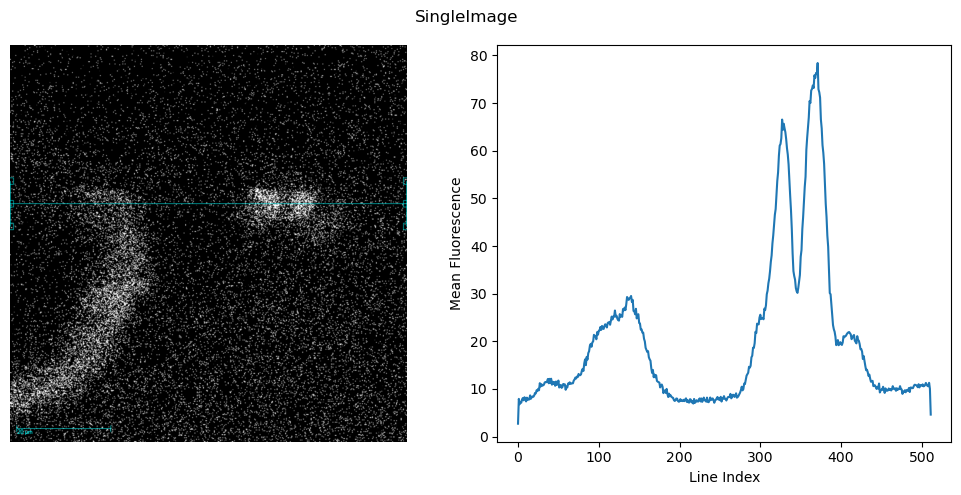

In [343]:
# determine ROI
counter = 63
data_directory = os.path.basename(sorted(list_subfolders_with_paths)[counter])
channels, windows = ['Ch1', 'Ch2'], ['Red', 'Green']
roi_index = 1 # green

h5name = f'{fly_path}/analysis/tiffs/{data_directory}.hdf5'

if os.path.exists(h5name):
    tiff_data = {}
    # read hdf5 file
    f = h5py.File(h5name, 'r')
    tiff_data['Ch2'] = f.get('Ch2')
    tiff_data['Ch1'] = f.get('Ch1')
else:
    print('File does not exist')

mean_f = np.mean(tiff_data[channels[roi_index]], axis=0)

ref_dir = f'{fly_path}/{data_directory}/References'
for filename in glob.glob(f'{ref_dir}/*{windows[roi_index]}*.tif'):
    ref_image = AICSImage(filename).data

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 
axes[0].imshow(ref_image[0][0][0])
axes[0].axis('off')

axes[1].plot(range(len(mean_f)), mean_f)
axes[1].set_ylabel('Mean Fluorescence')
axes[1].set_xlabel('Line Index')

fig.suptitle(data_directory)

plt.tight_layout()
plt.show()

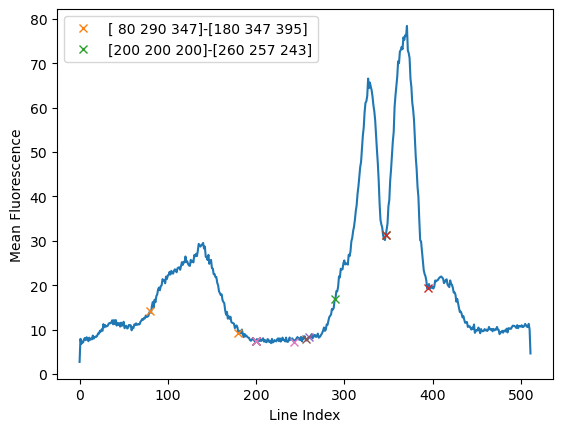

In [337]:
glom_start, glom_end = np.array([80, 290, 347]), np.array([180, 347, 395])
not_glom_start = np.array([200, 200, 200])
# not_glom_end = not_glom_start + (glom_end - glom_start)
not_glom_end = np.array([260, 257, 243])

plt.plot(range(len(mean_f)), mean_f, label='_nolegend_')
plt.plot([glom_start, glom_end], mean_f[[glom_start, glom_end]], "x")
plt.plot([not_glom_start, not_glom_end], mean_f[[not_glom_start, not_glom_end]], "x")
plt.ylabel('Mean Fluorescence')
plt.xlabel('Line Index')
plt.legend([f'{glom_start}-{glom_end}', f'{not_glom_start}-{not_glom_end}'])
plt.show()

In [338]:
# save ROIs
pklpath = pathlib.PurePath(f'{fly_path}/analysis/tiffs/')
pklname = os.path.join(pklpath, f'{data_directory}.pkl')

if not os.path.exists(pklname):
    # Saving the objects:
    with open(pklname, 'wb') as f:
        pickle.dump([glom_start, glom_end, not_glom_start, not_glom_end], f)
else:
    print('file exists, delete and overwrite')

counter = counter + 1
print(counter)

64


In [125]:
# function for averaging fluorescence in ROI
def get_roi_fluor(linescan_array, roi_start, roi_end):
    roi_fluor = []
    for idx, y in enumerate(linescan_array):
        roi_fluor.append(linescan_array[idx][roi_start:roi_end].mean())
    roi_fluor = np.array(roi_fluor)
    return roi_fluor

In [157]:
df_aligned

Time(ms)   Arena DAC1   Arena DAC1_cartx   Arena DAC1_carty
0         0.0000    -1.810481          -0.237396          -0.971413
1         2.9232    -1.812659          -0.239512          -0.970893
2         5.8464    -1.811884          -0.238759          -0.971079
3         8.7696    -1.811140          -0.238037          -0.971256
4        11.6928    -1.811386          -0.238275          -0.971198
...          ...          ...                ...                ...
6837  19985.9184    -1.810972          -0.237873          -0.971296
6838  19988.8416    -1.811869          -0.238744          -0.971082
6839  19991.7648    -1.812061          -0.238931          -0.971037
6840  19994.6880    -1.812168          -0.239035          -0.971011
6841      0.0000     0.000000           0.000000           0.000000

[6842 rows x 4 columns]

In [175]:
# add ROI fluorescence to csv
for f in list_subfolders_with_paths:
    basedir = pathlib.PurePath(f)
    data_directory = os.path.basename(f)
    basename_input = pathlib.Path(basedir.joinpath(data_directory))

    if ''.join(x for x in date_fly if x.isalpha()) in data_directory: #'LineScan' in data_directory: #
        csvname = f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/csvs/{data_directory}.csv'
        if os.path.exists(csvname):
            df_aligned = pd.read_csv(csvname)
        else:
            print(f'csv does not exist for {data_directory}')
        
        h5name = f'{fly_path}/analysis/tiffs/{data_directory}.hdf5'
        if os.path.exists(h5name):
            tiff_data = {}
            # read hdf5 file
            f = h5py.File(h5name, 'r')
            tiff_data['Ch2'] = f.get('Ch2')
            tiff_data['Ch1'] = f.get('Ch1')
        else:
            print(f'hdf5 file does not exist for {data_directory}')
        
        asap_array = tiff_data['Ch2']
        geco_array = tiff_data['Ch1']

        pklname = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/tiffs/{data_directory}.pkl')
        if os.path.exists(pklname):
            with open(pklname, 'rb') as f:
                glom_start, glom_end, not_glom_start, not_glom_end = pickle.load(f)
        else:
            print(f'ROI pickle does not exist for {data_directory}')

        # ch2 fluorescence and background
        ch2_fluor, ch2_bg = np.empty((len(glom_start), len(asap_array))), np.empty((len(glom_start), len(asap_array)))
        for idx, y in enumerate(glom_start):
            ch2_fluor[idx, :] = get_roi_fluor(asap_array, y, glom_end[idx])
            ch2_bg[idx, :] = get_roi_fluor(asap_array, not_glom_start[idx], not_glom_end[idx])

        # ch1 fluorescence and background
        ch1_fluor, ch1_bg = np.empty((len(glom_start), len(geco_array))), np.empty((len(glom_start), len(geco_array)))
        for idx, y in enumerate(glom_start):
            ch1_fluor[idx, :] = get_roi_fluor(geco_array, y, glom_end[idx])
            ch1_bg[idx, :] = get_roi_fluor(geco_array, not_glom_start[idx], not_glom_end[idx]) 

        if len(df_aligned) != len(asap_array):
            len_diff = len(asap_array) - len(df_aligned)
            if len_diff > 0:
                rows_to_add = np.linspace(df_aligned.shape[0], len(asap_array), len_diff, dtype='int')
                nan_array = np.zeros(df_aligned.shape[1])
                nan_array[:] = np.nan
                for r in rows_to_add:
                    df_aligned.loc[r] = nan_array
            elif len_diff < 0:
                nan_array = np.zeros(len_diff)
                nan_array[:] = np.nan
                ch2_fluor, ch2_bg, ch1_fluor, ch1_bg = np.append(ch2_fluor, nan_array), np.append(ch2_bg, nan_array), np.append(ch1_fluor, nan_array), np.append(ch1_bg, nan_array)

        # create dataframe with voltage recording data and ROI fluorescence
        for idx, roi in enumerate(ch2_fluor):
            roi_num = idx + 1
            df_aligned[f'Ch2 ROI {roi_num}'] = roi
            df_aligned[f'Ch2 bg ROI {roi_num}'] = ch2_bg[idx]
            df_aligned[f'Ch1 ROI {roi_num}'] = ch1_fluor[idx]
            df_aligned[f'Ch1 bg ROI {roi_num}'] = ch1_bg[idx]

        # save dataframe
        csvname = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/roi_csvs/{data_directory}.csv')
        os.makedirs(csvname.parent, exist_ok=True)
        df_aligned.to_csv(csvname, index=False)

# Plot multiple glomeruli

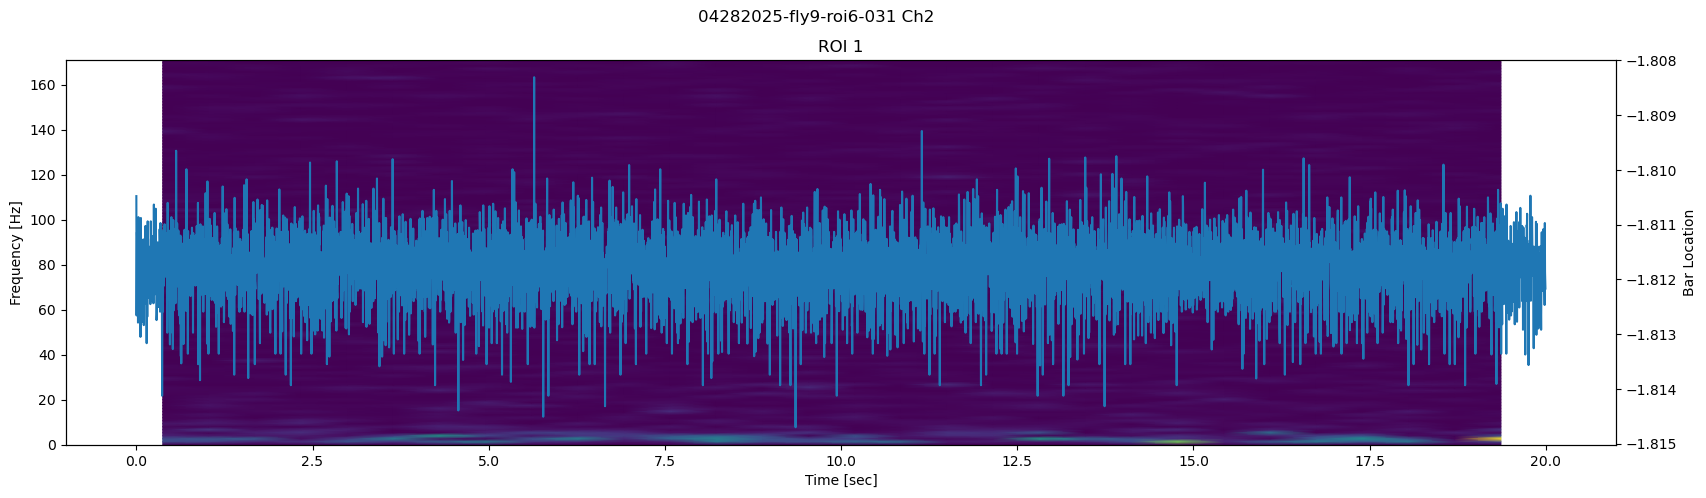

In [100]:
microscope = "Galadriel"
effector = "ASAP7y_jrGECO1a"
driver = "ER4d-split"
date_fly = "250428_fly9"
data_directory = "04282025-fly9-roi6-031"

basedir = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/{data_directory}')
basename_input = pathlib.Path(basedir.joinpath(data_directory))

metadata = st2p.preprocessing_tools.bruker_metadata.read(basename_input)

csvname = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/roi_csvs/{data_directory}.csv')
df_trial = pd.read_csv(csvname)

channels = ['Ch1', 'Ch2']
num_roi = len([col for col in df_trial.columns if 'ROI' in col]) / (len(channels)*2)

corr_roi_fluor = {channel: {} for channel in channels}
for c in channels:
    for n in np.arange(1, num_roi+1, 1, dtype=int):
        corr_roi_fluor[c][n] = df_trial[f'{c} ROI {n}'] - df_trial[f'{c} bg ROI {n}']

plot_channel = channels[1]
fig, axs = plt.subplots(1, int(num_roi), figsize=(20, 5))
for n in np.arange(1, num_roi+1, 1, dtype=int):
    if num_roi > 1:
        taxs = spectrogram_with_arena(axs[n-1], corr_roi_fluor[plot_channel][n], df_trial, metadata)
        axs[n-1].set_title(f'ROI {n}')
    else:
        taxs = spectrogram_with_arena(axs, corr_roi_fluor[plot_channel][n], df_trial, metadata)
        axs.set_title(f'ROI {n}')

fig.suptitle(f'{data_directory} {plot_channel}')
# axs.set_ylim(0, 10)
# taxs.set_ylim(-10, 0)
plt.show()


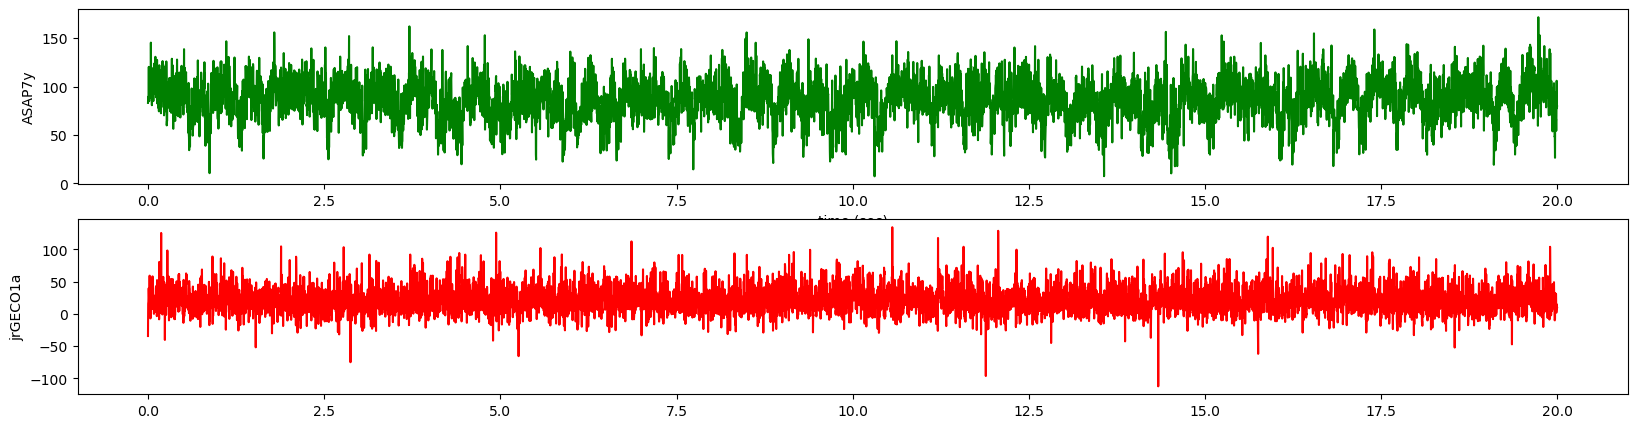

In [101]:
roi_num = 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 5))
# ax2 = ax1.twinx()
ax1.plot(df_trial['Time(ms)']/1000, corr_roi_fluor['Ch2'][roi_num], 'green')
ax1.set_ylabel('ASAP7y')
ax2.plot(df_trial['Time(ms)']/1000, corr_roi_fluor['Ch1'][roi_num], 'red')
ax2.set_ylabel('jrGECO1a')

ax1.set_xlabel('time (sec)')
# ax1.set_xlim(20, 30)

plt.show()

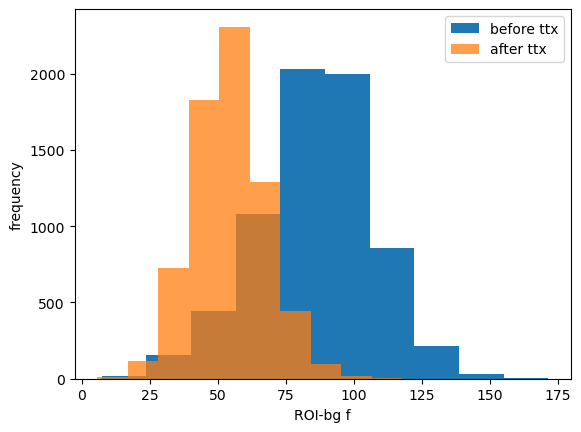

In [104]:
# after_ttx = corr_roi_fluor['Ch2'][roi_num]

plt.hist(corr_roi_fluor['Ch2'][roi_num])
plt.hist(after_ttx, alpha=0.75)
plt.legend(['before ttx', 'after ttx'])
plt.ylabel('frequency')
plt.xlabel('ROI-bg f')
plt.show()

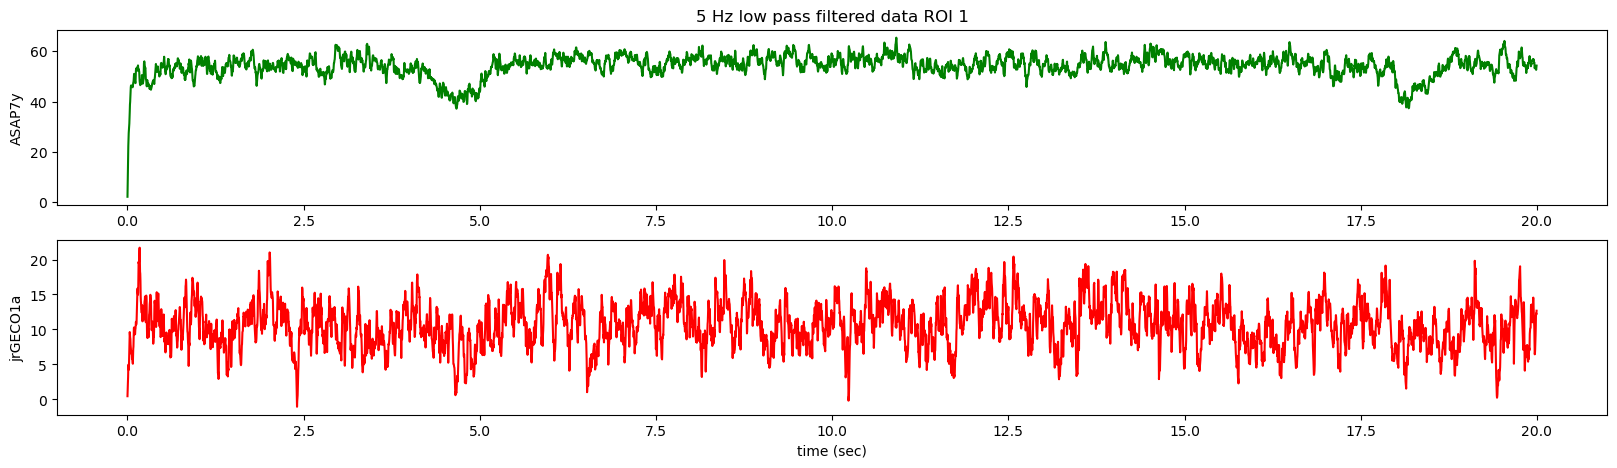

In [85]:
red_trace = corr_roi_fluor['Ch1'][roi_num]
green_trace = corr_roi_fluor['Ch2'][roi_num]

cutoff = 5

time = df_trial['Time(ms)']
samp_rate = 1/metadata['linescan_size']['scan_line_period']

lowpass_green = butter_lowpass_filter(green_trace, cutoff, samp_rate, 1)
lowpass_red = butter_lowpass_filter(red_trace, cutoff, samp_rate, 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 5))
# ax2 = ax1.twinx()
ax1.plot(df_trial['Time(ms)']/1000, lowpass_green, 'green')
ax1.set_ylabel('ASAP7y')
ax2.plot(df_trial['Time(ms)']/1000, lowpass_red, 'red')
ax2.set_ylabel('jrGECO1a')
ax2.set_xlabel('time (sec)')

# ax1.set_xlim(20, 40)

ax1.set_title(f'{cutoff} Hz low pass filtered data ROI {roi_num}')

plt.show()

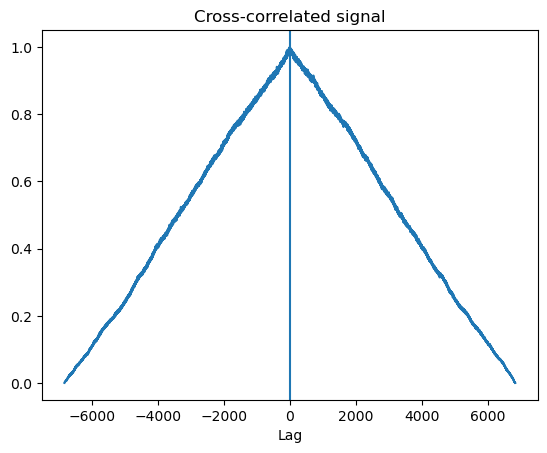

In [86]:
# cross correlation
corr = sp.signal.correlate(green_trace, red_trace, mode='full')
lags = sp.signal.correlation_lags(len(green_trace), len(red_trace), mode="full")
corr /= np.max(corr)

plt.plot(lags, corr)
plt.title('Cross-correlated signal')
plt.xlabel('Lag')
plt.axvline(x = 0)
plt.show()

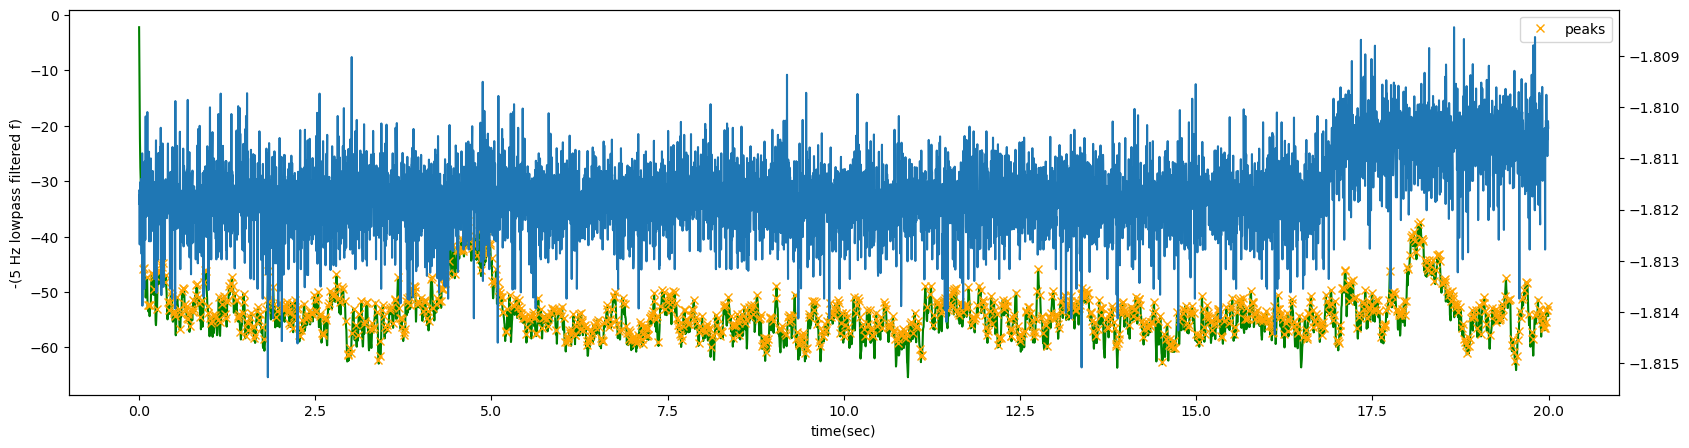

In [87]:
glom_fluor_corr = corr_roi_fluor['Ch2'][roi_num]
glom_red_fluor_corr = corr_roi_fluor['Ch1'][roi_num]

cutoff = 5

time = df_trial['Time(ms)']
samp_rate = 1/metadata['linescan_size']['scan_line_period']

lowpass = butter_lowpass_filter(glom_fluor_corr, cutoff, samp_rate, 1)

flipped_lowpass = -lowpass

peaks, properties = sp.signal.find_peaks(flipped_lowpass, prominence=(None, None))#, wlen=100)#, width=(25,75))

title = '>30 peak prominences no wlen 5 Hz lowpass data'

fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()
# plt.figure(figsize=(20, 5))
ax1.plot(df_trial['Time(ms)']/1000, flipped_lowpass, color='green', label='_nolegend_')
ax1.plot(peaks*metadata['linescan_size']['scan_line_period'], flipped_lowpass[peaks], 'x', color='orange')
ax1.legend(['peaks'])

ax2.plot(df_trial['Time(ms)']/1000, np.unwrap(df_trial[' Arena DAC1']))

ax1.set_xlabel('time(sec)')
ax1.set_ylabel(f'-({cutoff} Hz lowpass filtered f)')
# ax1.set_xlim(20, 30)
plt.show()

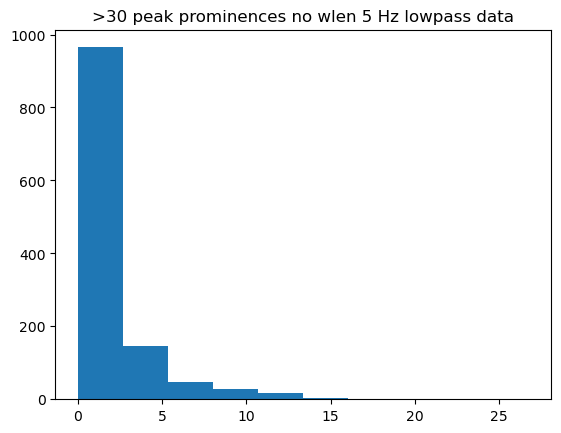

In [88]:
plt.hist(properties['prominences'])
plt.title(title)
plt.show()

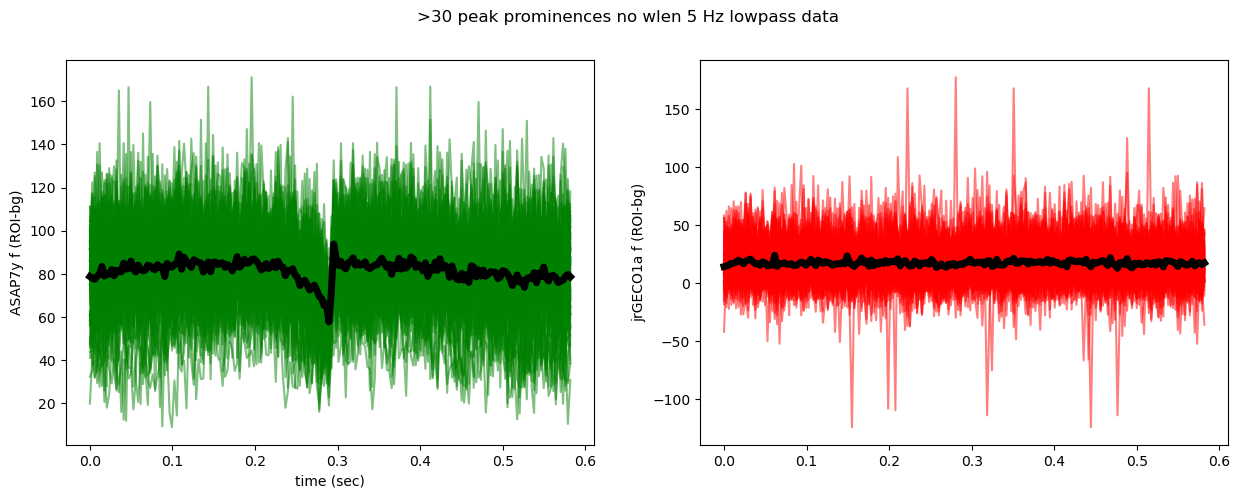

In [80]:
before = 100
after = 100

before_array = peaks - before
after_array = peaks + after

before_array[before_array < 0] = 0
after_array[after_array > len(glom_fluor_corr)] = len(glom_fluor_corr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

average_burst = np.zeros((len(before_array), before+after))
red_average_burst = np.zeros((len(before_array), before+after))
for idx, v in enumerate(before_array):
    current_burst = glom_fluor_corr[v:after_array[idx]]
    red_current_burst = glom_red_fluor_corr[v:after_array[idx]]

    if len(current_burst) < before+after:
        nan_array = np.zeros(before+after-len(current_burst))
        nan_array[:] = np.nan
        if v == 0:
            current_burst = np.concatenate((nan_array, np.array(current_burst)))
            red_current_burst = np.concatenate((nan_array, np.array(red_current_burst)))
        else:
            current_burst = np.concatenate((np.array(current_burst), nan_array))
            red_current_burst = np.concatenate((np.array(red_current_burst), nan_array))

    burst_time = np.arange(0, len(current_burst)/samp_rate, 1/samp_rate)

    ax1.plot(burst_time, current_burst, color='green', alpha=0.5)
    ax2.plot(burst_time, red_current_burst, color='red', alpha=0.5)

    average_burst[idx,:] = current_burst
    red_average_burst[idx,:] = red_current_burst

average_burst = np.nanmean(average_burst, axis=0)
red_average_burst = np.nanmean(red_average_burst, axis=0)
ax1.plot(burst_time, average_burst, color='black', linewidth=5)
ax2.plot(burst_time, red_average_burst, color='black', linewidth=5)

# axes labels
ax1.set_ylabel('ASAP7y f (ROI-bg)')
ax2.set_ylabel('jrGECO1a f (ROI-bg)')
ax1.set_xlabel('time (sec)')

fig.suptitle(title)
# ax1.set_xlim(0.15, 0.35)

plt.show()

In [36]:
long_peaks = peaks

In [ ]:
short_peaks = peaks

array([  273,   450,   719,   935,  1136,  1356,  1599,  1936,  2212,
        2262,  2304,  2565,  2609,  2835,  3082,  3502,  3783,  4023,
        4295,  4614,  4832,  5372,  5776,  5907,  6084,  6301,  6672,
        6924,  7120,  7348,  7598,  7869,  8171,  8368,  8551,  8796,
        9094,  9398,  9741, 10164, 10512, 10844, 11078, 11700, 11948,
       12164, 12641, 12968, 13075, 13472, 13751, 14497, 14794, 15025,
       15260, 15402, 15566, 15819, 16026, 16209, 16421, 16649, 16921])

In [41]:
metadata['linescan_size']['scan_line_period']

0.0029232

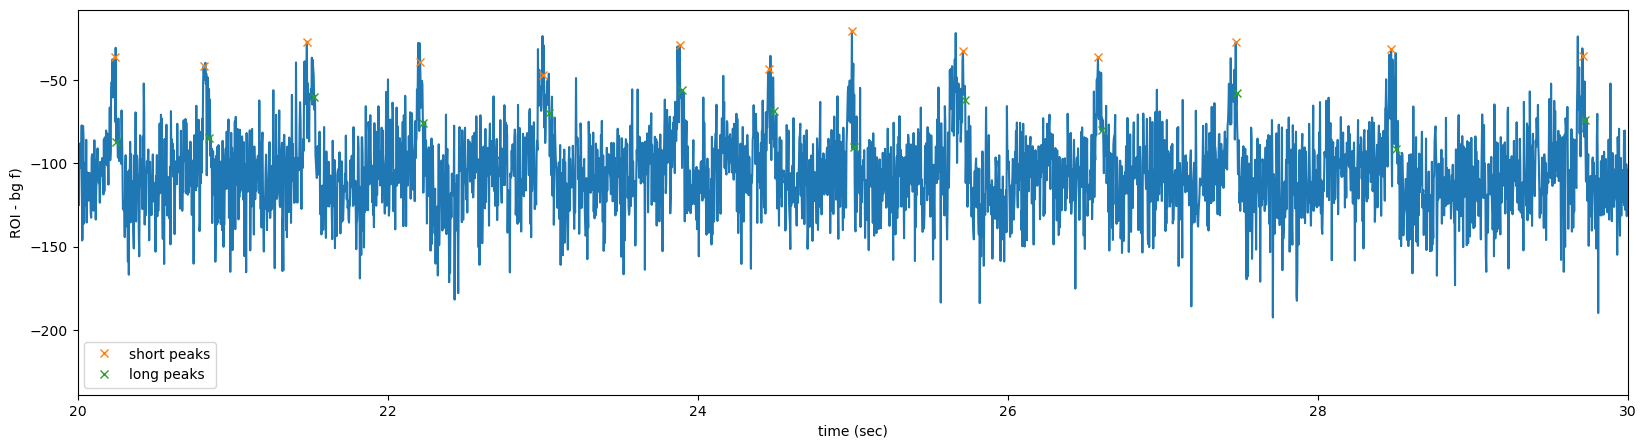

In [45]:
plt.figure(figsize=(20, 5))
plt.plot(df_trial['Time(ms)']/1000, -glom_fluor_corr, label='_nolegend_')
plt.plot(short_peaks*metadata['linescan_size']['scan_line_period'], -glom_fluor_corr[short_peaks], 'x')
plt.plot(long_peaks*metadata['linescan_size']['scan_line_period'], -glom_fluor_corr[long_peaks], 'x')
plt.legend(['short peaks', 'long peaks'])
plt.xlabel('time (sec)')
plt.ylabel(f'ROI - bg f)')
plt.xlim(20, 30)
plt.show()

In [65]:
fly_path = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}')
list_subfolders_with_paths = sorted([f.path for f in os.scandir(fly_path) if f.is_dir()])

f_to_analyze = [7, 8, 9]
roi_num = 1

channels = ['Ch1', 'Ch2']
avg_response = {channel: {} for channel in channels}
for idx, f in enumerate(f_to_analyze):
    basedir = pathlib.PurePath(list_subfolders_with_paths[f])
    data_directory = os.path.basename(list_subfolders_with_paths[f])
    csvname = pathlib.PurePath(f'{fly_path}/analysis/roi_csvs/{data_directory}.csv')
    df_trial = pd.read_csv(csvname)

    num_roi = len([col for col in df_trial.columns if 'ROI' in col]) / (len(channels)*2)

    corr_roi_fluor = {channel: {} for channel in channels}
    for c in channels:
        for n in np.arange(1, num_roi+1, 1, dtype=int):
            corr_roi_fluor[c][n] = df_trial[f'{c} ROI {n}'] - df_trial[f'{c} bg ROI {n}']

        avg_response[c][idx] = corr_roi_fluor[c][roi_num]

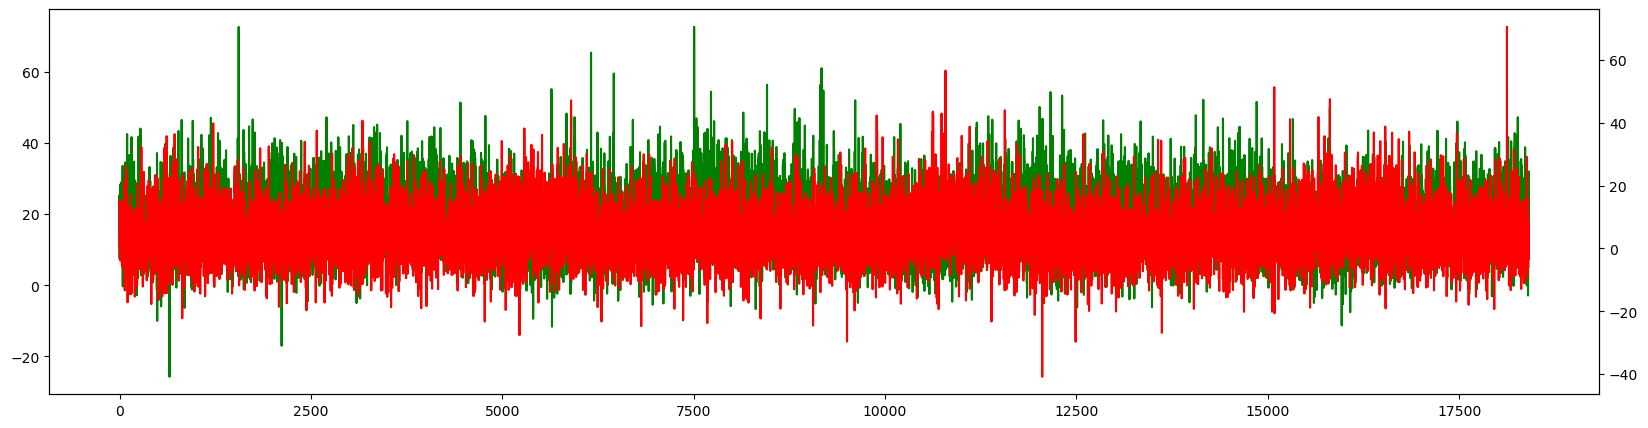

In [74]:
red_arrays = [np.array(avg_response['Ch1'][l]) for l in avg_response['Ch1']]
green_arrays = [np.array(avg_response['Ch2'][l]) for l in avg_response['Ch2']]

avg_red = np.mean(red_arrays, axis=0)
avg_green = np.mean(green_arrays, axis=0)

fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()
ax1.plot(avg_green, color='green')
ax2.plot(avg_red, color='red')
# ax1.set_xlim(2500, 7500)
plt.show()

# Open individual trial folders

In [ ]:
# access data in downloads folder
data_directory = 'LineScan-04082025-1531-fly4-036'

basedir = pathlib.PurePath(f'/Users/lilynguyen/Downloads/{data_directory}')
basename_input = pathlib.Path(basedir.joinpath(data_directory))
metadata = st2p.preprocessing_tools.bruker_metadata.read(basename_input)

In [18]:
# access data on hard drive
microscope = "Galadriel"
effector = "ASAP7y_jrGECO1a"
driver = "ER4d-split"
date_fly = "250418_fly7"
data_directory = '04182025-fly7-soma-r1-007'

basedir = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/{data_directory}')
basename_input = pathlib.Path(basedir.joinpath(data_directory))
metadata = st2p.preprocessing_tools.bruker_metadata.read(basename_input)

In [ ]:
# reformat tiffs
tiff_data = st2p.preprocessing_tools.tiff_tools.read_linescan(basename_input, metadata['linescan_size'])

(2, 3, 8192, 512)


In [19]:
# interpolate bruker voltage recording
end_time = metadata['frame_times'][0][-1] + (metadata['linescan_size']['scan_line_period'] * (metadata['linescan_size']['y_px_last_frame'] - 1))
frame_times = np.arange(0, end_time, metadata['linescan_size']['scan_line_period']) * 1000 # ms

voltage_recording_csv = str(basename_input) + f'_Cycle00001_VoltageRecording_001.csv'
df = pd.read_csv(voltage_recording_csv)
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

# Open and analyze hdf5 file

In [3]:
# open hdf5 file
microscope = "Galadriel"
effector = "ASAP7y_jrGECO1a"
driver = "ER4d-split"
date_fly = "250418_fly7"
data_directory = '04182025-fly7-soma-r1-001'

h5name = f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/tiffs/{data_directory}.hdf5'

if os.path.exists(h5name):
    tiff_data = {}
    # read hdf5 file
    f = h5py.File(h5name, 'r')
    tiff_data['Ch2'] = f.get('Ch2')
    tiff_data['Ch1'] = f.get('Ch1')
else:
    print('hdf5 does not exist')

pklname = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/tiffs/{data_directory}.pkl')

if os.path.exists(pklname):
    with open(pklname, 'rb') as f:
        glom_start, glom_end, not_glom_start, not_glom_end = pickle.load(f)
else:
    print('ROI pickle does not exist')

basedir = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/{data_directory}')
basename_input = pathlib.Path(basedir.joinpath(data_directory))
metadata = st2p.preprocessing_tools.bruker_metadata.read(basename_input)

# Plot and average fluorescence to determine ROI

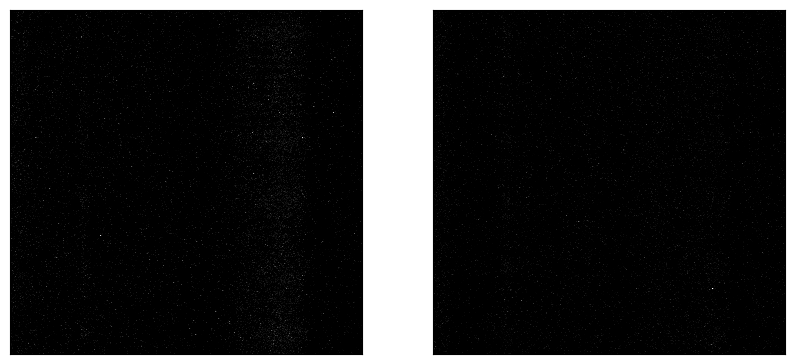

In [5]:
# plot first 500 lines from each channel
fig, ax = plt.subplots(1, len(tiff_data.keys()), figsize=(10,20))

for i, c in enumerate(tiff_data.keys()):
    ax[i].imshow(tiff_data[c][0:500], cmap='Greys_r', interpolation='nearest')
    ax[i].set_yticks([])
    ax[i].set_xticks([])

In [4]:
# function for getting the mean across y values
def get_mean_f(np_arrays):
    return np.mean(np_arrays, axis=0)

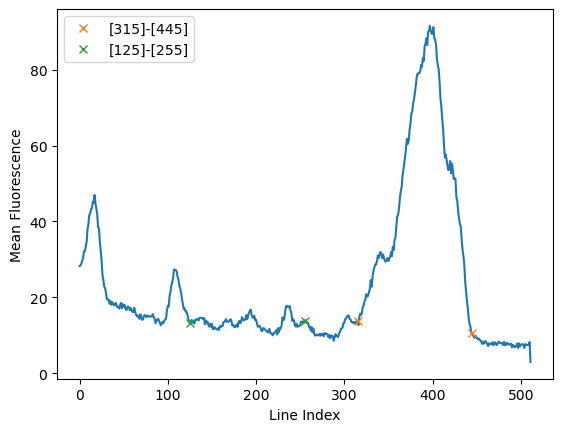

In [22]:
# average fluorescence from all line scans and plot to find glomeruli area
asap_array = tiff_data['Ch2']
geco_array = tiff_data['Ch1']

mean_f = get_mean_f(asap_array)

glom_start = [315]
glom_end = [445]

not_glom_start = [125]
not_glom_end = [255]

plt.plot(range(len(mean_f)), mean_f, label='_nolegend_')
plt.plot([glom_start, glom_end], mean_f[[glom_start, glom_end]], "x")
plt.plot([not_glom_start, not_glom_end], mean_f[[not_glom_start, not_glom_end]], "x")
plt.ylabel('Mean Fluorescence')
plt.xlabel('Line Index')
plt.legend([f'{glom_start}-{glom_end}', f'{not_glom_start}-{not_glom_end}'])
plt.show()

In [129]:
# write and read ROIs
pklpath = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/tiffs/')
pklname = os.path.join(pklpath, f'{data_directory}.pkl')

if not os.path.exists(pklname):
    # Saving the objects:
    with open(pklname, 'wb') as f:
        pickle.dump([glom_start, glom_end, not_glom_start, not_glom_end], f)
else:
    with open(pklname, 'rb') as f:
        glom_start, glom_end, not_glom_start, not_glom_end = pickle.load(f)


# Add ROI fluorescence to csv

In [9]:
asap_array = tiff_data['Ch2']
geco_array = tiff_data['Ch1']

csvname = f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/csvs/{data_directory}.csv'
if os.path.exists(csvname):
    df_aligned = pd.read_csv(csvname)
else:
    print('csv does not exist')

In [10]:
# function for averaging fluorescence in ROI
def get_roi_fluor(linescan_array, roi_start, roi_end):
    roi_fluor = []
    for idx, y in enumerate(linescan_array):
        roi_fluor.append(linescan_array[idx][roi_start:roi_end].mean())
    roi_fluor = np.array(roi_fluor)
    return roi_fluor

In [11]:
# ch2 fluorescence and background
ch2_fluor, ch2_bg = np.empty((len(glom_start), len(asap_array))), np.empty((len(glom_start), len(asap_array)))
for idx, y in enumerate(glom_start):
    ch2_fluor[idx, :] = get_roi_fluor(asap_array, y, glom_end[idx])
    ch2_bg[idx, :] = get_roi_fluor(asap_array, not_glom_start[idx], not_glom_end[idx])

# ch1 fluorescence and background
ch1_fluor, ch1_bg = np.empty((len(glom_start), len(geco_array))), np.empty((len(glom_start), len(geco_array)))
for idx, y in enumerate(glom_start):
    ch1_fluor[idx, :] = get_roi_fluor(geco_array, y, glom_end[idx])
    ch1_bg[idx, :] = get_roi_fluor(geco_array, not_glom_start[idx], not_glom_end[idx])

In [12]:
# create dataframe with voltage recording data and ROI fluorescence
for idx, roi in enumerate(ch2_fluor):
    roi_num = idx + 1
    df_aligned[f'Ch2 ROI {roi_num}'] = roi
    df_aligned[f'Ch2 bg ROI {roi_num}'] = ch2_bg[idx]
    df_aligned[f'Ch1 ROI {roi_num}'] = ch1_fluor[idx]
    df_aligned[f'Ch1 bg ROI {roi_num}'] = ch1_bg[idx]

df_aligned.head()

Time(ms)   Arena DAC1   Arena DAC1_cartx   Arena DAC1_carty  Ch2 ROI 1  \
0    0.0000    -1.806838          -0.233856          -0.972271  48.630769   
1    2.9232    -1.808908          -0.235868          -0.971785  68.615385   
2    5.8464    -1.809415          -0.236360          -0.971665  42.469231   
3    8.7696    -1.809039          -0.235995          -0.971754  37.400000   
4   11.6928    -1.808793          -0.235757          -0.971812  49.553846   

   Ch2 bg ROI 1  Ch1 ROI 1  Ch1 bg ROI 1  
0     15.923077  22.738462      9.061538  
1     23.230769  12.961538     13.446154  
2     13.984615  15.376923     26.869231  
3     24.876923  25.730769     28.961538  
4      9.030769  20.361538      9.769231

In [13]:
# save dataframe
csvname = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/csvs/{data_directory}.csv')

df_aligned.to_csv(csvname, index=False)

# Quick plots

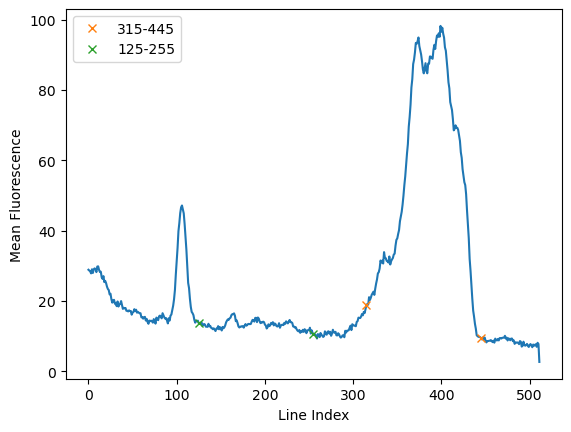

In [15]:
# average fluorescence from all line scans and plot to find glomeruli area
asap_array = tiff_data['Ch2']
geco_array = tiff_data['Ch1']

mean_f = get_mean_f(asap_array)

glom_start = 315
glom_end = 445

not_glom_start = 125
not_glom_end = 255

plt.plot(range(len(mean_f)), mean_f, label='_nolegend_')
plt.plot([glom_start, glom_end], mean_f[[glom_start, glom_end]], "x")
plt.plot([not_glom_start, not_glom_end], mean_f[[not_glom_start, not_glom_end]], "x")
plt.ylabel('Mean Fluorescence')
plt.xlabel('Line Index')
plt.legend([f'{glom_start}-{glom_end}', f'{not_glom_start}-{not_glom_end}'])
plt.show()

In [21]:
# create an array with the average fluorescence of the ROI during each line scan
data_array = asap_array

glom_fluor = []
for idx, y in enumerate(data_array):
    glom_fluor.append(data_array[idx][glom_start:glom_end].mean()) # could make for loop to iterate through multiple ROIs
glom_fluor = np.array(glom_fluor)

In [22]:
not_glom_fluor = []
for idx, y in enumerate(data_array):
    not_glom_fluor.append(data_array[idx][not_glom_start:not_glom_end].mean()) # could make for loop to iterate through multiple ROIs
not_glom_fluor = np.array(not_glom_fluor)

In [23]:
glom_fluor_corr = glom_fluor - not_glom_fluor

In [24]:
metadata['linescan_size']

{'frames': 3,
 'channels': 2,
 'y_px_frame': 8192,
 'x_px_line': 512,
 'y_px_last_frame': 721,
 'scan_line_period': 0.0029232}

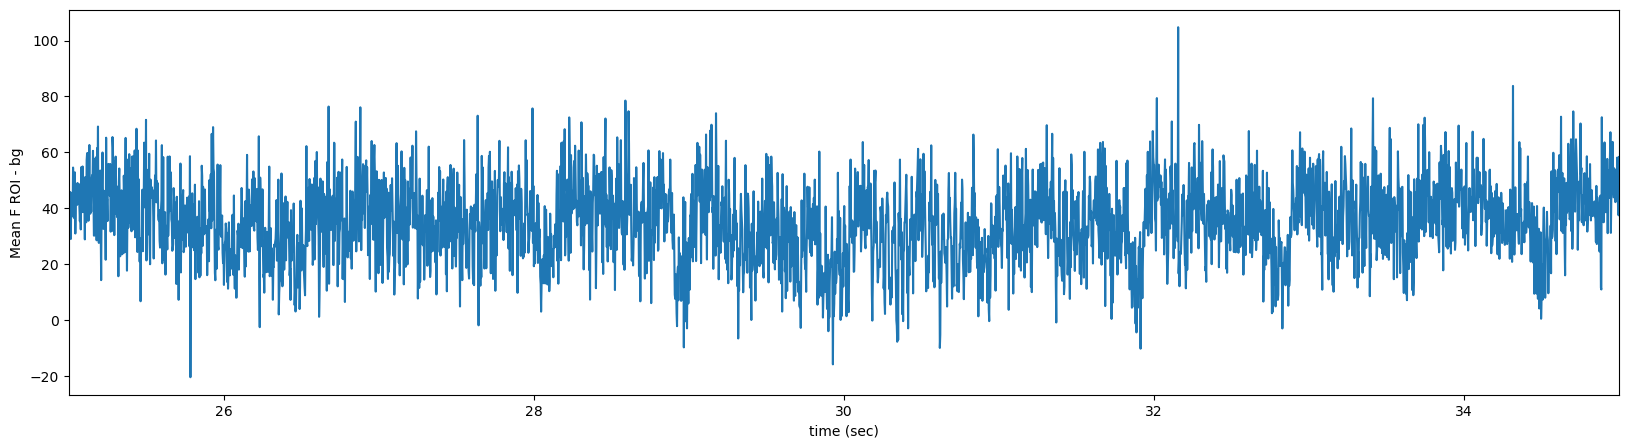

In [51]:
plot_data = glom_fluor_corr

# plot raw fluorescence
end_time = ((metadata['linescan_size']['y_px_frame'] * metadata['linescan_size']['frames']) - (metadata['linescan_size']['y_px_frame'] - metadata['linescan_size']['y_px_last_frame'])) * metadata['linescan_size']['scan_line_period']
time = np.arange(0, end_time, metadata['linescan_size']['scan_line_period'])

plt.figure(figsize=(20, 5))
plt.plot(time[0:-1], plot_data)
plt.xlim(25, 35)
plt.ylabel('Mean F ROI - bg')
plt.xlabel('time (sec)')
plt.show()

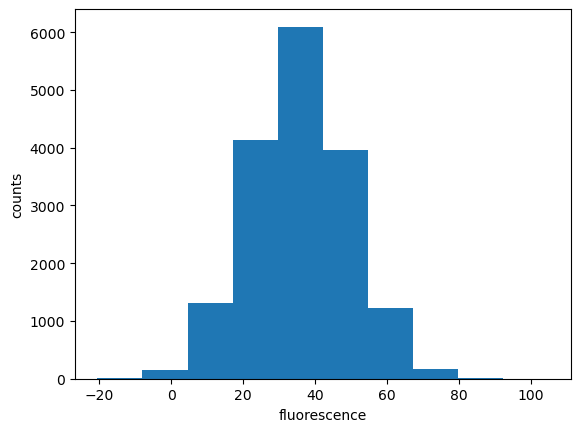

In [21]:
# plot fluorescence distribution
plt.hist(glom_fluor_corr)
plt.ylabel('counts')
plt.xlabel('fluorescence')
plt.show()

In [30]:
analyze_data = glom_fluor_corr #+ glom_fluor_red_corr

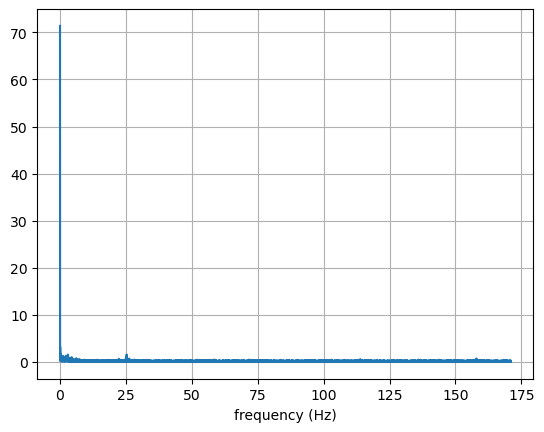

In [31]:
# plot frequencies
from scipy.fft import fft, fftfreq
# Number of sample points
N = len(analyze_data)
# sample spacing
T = metadata['linescan_size']['scan_line_period']
x = time[0:-1]
y = analyze_data
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.xlim(0, 1)
plt.xlabel('frequency (Hz)')
plt.grid()
plt.show()

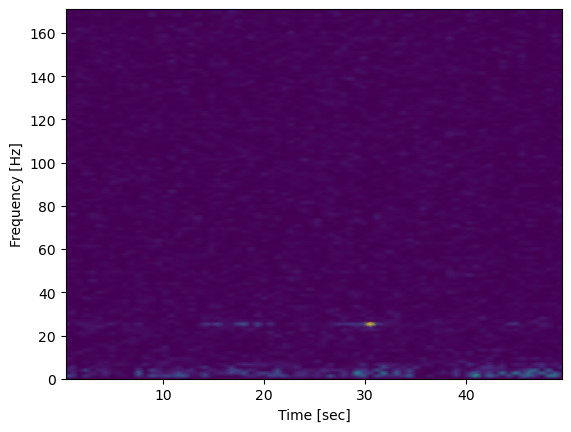

In [36]:
# spectrogram
fs = 1 / metadata['linescan_size']['scan_line_period']
f, t, Sxx = sp.signal.spectrogram(analyze_data, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
# plt.ylim(0, 10)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
# spectrogram with arena location overlaid

fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()

ax1.pcolormesh(t, f, Sxx, shading='gouraud')
ax1.set_ylim(0, 50)
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [sec]')

ax2.plot(time[0:-1], np.unwrap(df_aligned[' Arena DAC1']))
ax2.set_ylabel('Bar Location')
plt.show()

In [2]:
def spectrogram_with_arena(ax1, fluor, df_trial, metadata):
    fs = 1 / metadata['linescan_size']['scan_line_period']
    f, t, Sxx = sp.signal.spectrogram(fluor, fs)
    
    ax2 = ax1.twinx()

    ax1.pcolormesh(t, f, Sxx, shading='gouraud')
    ax1.set_ylabel('Frequency [Hz]')
    ax1.set_xlabel('Time [sec]')

    ax2.plot(df_trial['Time(ms)']/1000, np.unwrap(df_trial[' Arena DAC1']))
    ax2.set_ylabel('Bar Location')

    return ax2

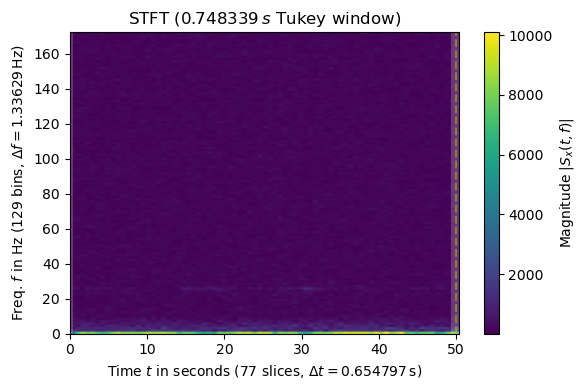

In [ ]:
# short time FFT spectrogram
x = np.array(analyze_data)
T_x = samp_rate
N = len(analyze_data)
t_x = df_trial['Time(ms)']

w = sp.signal.windows.tukey(256, alpha=0.25) # spectrogram default
SFT = sp.signal.ShortTimeFFT(w, hop=int(256-256/8), fs=T_x)#, scale_to='magnitude')
Sx = SFT.stft(x)  # perform the STFT

fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Tukey window)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')
# ax1.plot(t_x, f_i, 'r--', alpha=.5, label='$f_i(t)$')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)
# ax1.legend()
# ax1.set_ylim(0, 50)
fig1.tight_layout()
plt.show()

In [ ]:
# periodogram
# Calculating the periodogram
frequencies, powers = sp.signal.periodogram(signal, fs)

# Plotting the periodogram
plt.semilogy(frequencies, powers)
plt.title('Periodogram of a Bird Chirp')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.show()

In [3]:
# low pass from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
def butter_lowpass(cutoff, fs, order=5):
    return sp.signal.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sp.signal.lfilter(b, a, data)
    return y

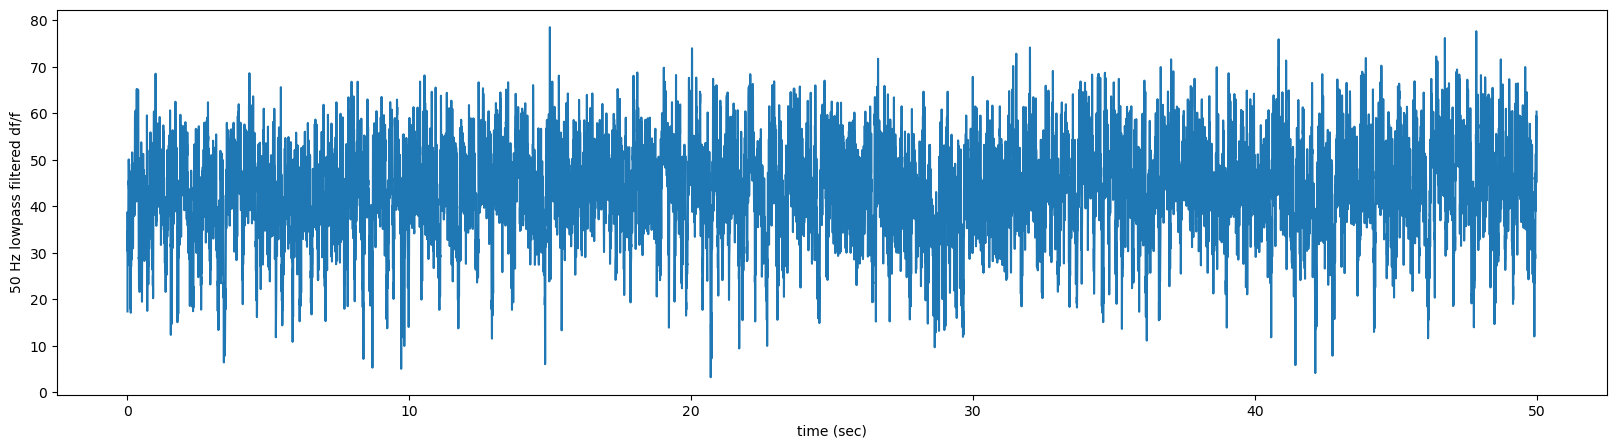

In [30]:
# lowpass filter data
cutoff = 50 # Hz
lowpass = butter_lowpass_filter(dff_glom, cutoff, 1/metadata['linescan_size']['scan_line_period'], 1)

plt.figure(figsize=(20, 5))
plt.plot(time[0:-1], lowpass)
plt.xlabel('time (sec)')
plt.ylabel(f'{cutoff} Hz lowpass filtered df/f')
plt.show()

In [96]:
# bandpass recipe (https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html)
def butter_bandpass(lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sp.signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sp.signal.lfilter(b, a, data)
    return y

In [ ]:
lowcut = 20
highcut = 30

bandpass = butter_bandpass_filter(analyze_data, lowcut, highcut, 1/metadata['linescan_size']['scan_line_period'], order=1)

plt.figure(figsize=(20, 5))
plt.plot(time[0:-1], bandpass)
plt.xlabel('time (sec)')
plt.ylabel(f'{lowcut}-{highcut} Hz bandpass filtered df/f')
plt.show()

In [38]:
# read in voltage csv
voltage_recording_csv = str(basename_input) + f'_Cycle00001_VoltageRecording_001.csv'
df = pd.read_csv(voltage_recording_csv)

# define csv columns as variables
voltage_time = df['Time(ms)']

if ' Arena DAC1' in df.columns:
    arena_loc = df[' Arena DAC1']
    arena_scene = df[' Arena DAC2']
elif ' Arena DAC' in df.columns:
    arena_loc = df[' Arena DAC']

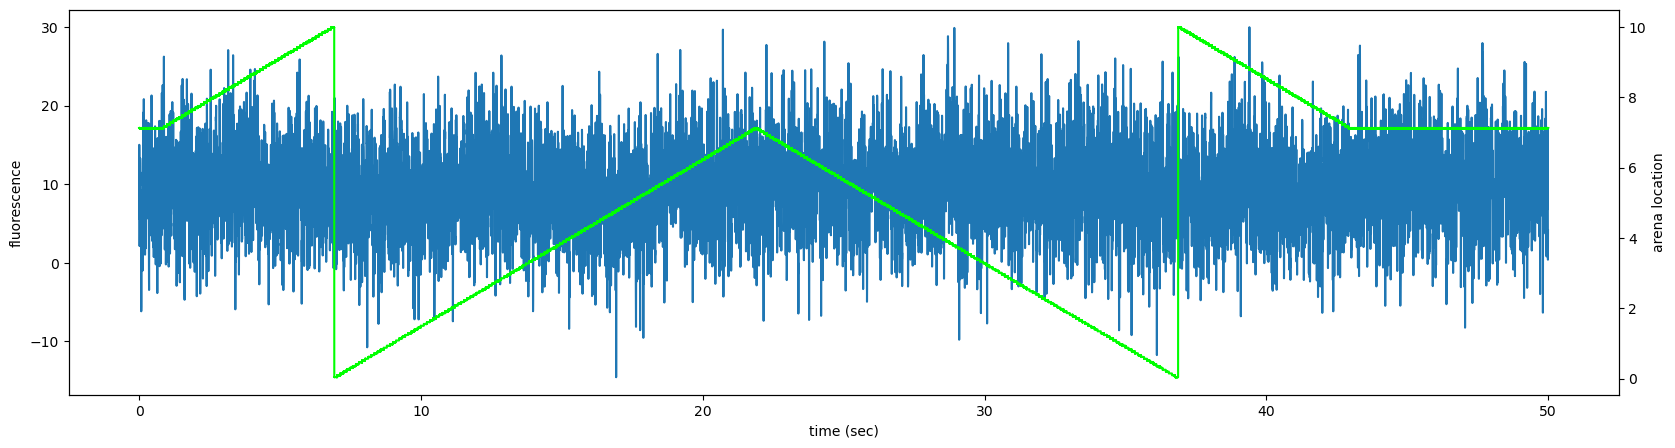

In [40]:
# plot imaging data vs arena location
plot_data = lowpass

fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()
# ax1.set_xlim((20, 35))

ax1.plot(time[0:-1], plot_data)
ax1.set_xlabel('time (sec)')
ax1.set_ylabel('fluorescence')
ax2.plot(voltage_time/1000, arena_loc, color='lime')
ax2.set_ylabel('arena location')

plt.show()

In [41]:
# functions for aligning data
def make_periodic(array):
    if array.any():
        sorted = np.sort(array)
        return np.linspace(sorted[0], sorted[-1], len(sorted)).round().astype(int)
    else:
        return np.empty((0,0))

def align_data(data, starts, ends):
    if starts.any():
        rows, columns = len(starts), int(np.unique(ends-starts)[0])
        aligned_matrix = np.empty((rows, columns))
        for idx, n in enumerate(starts):
            aligned_matrix[idx,:] = data[int(n):int(ends[idx])]
        return aligned_matrix
    else:
        return np.empty((0,0))

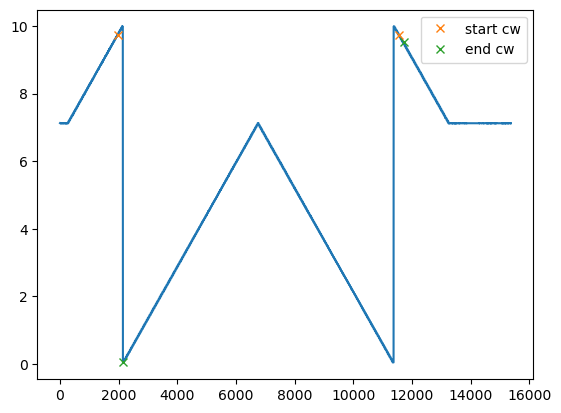

In [42]:
# interpolate voltage recording data
total_samples = len(arena_loc)
interp_pts = metadata['linescan_size']['scan_line_period'] / (voltage_time[1]/1000)

xvals = np.arange(0, total_samples, interp_pts)
arena_interp = np.interp(xvals, np.linspace(0, total_samples, total_samples), arena_loc)
interp_time = np.interp(xvals, np.linspace(0, total_samples, total_samples), voltage_time)/1000
# plt.plot(interp_time, arena_interp, '.-')
# plt.show()


# round values to integers
rounded = arena_interp.round()
# plt.plot(rounded, '.-')
# plt.show()


# determine peaks in arena location
min_distance = 0.5 / metadata['linescan_size']['scan_line_period'] # num samples in 0.5 sec
arena_peaks, properties = sp.signal.find_peaks(rounded, height=(10, None), distance=min_distance, prominence=(None, None))
# plt.plot(arena_interp)
# plt.plot(arena_peaks, arena_interp[arena_peaks], "x")
# plt.plot(properties['left_bases'], arena_interp[properties['left_bases']],"x")
# plt.plot(properties['right_bases'], arena_interp[properties['right_bases']],"x")
# plt.ylabel('Arena angle')
# plt.xlabel('sample')
# plt.show()


# sort cw and ccw rotations
peak_right_diff = properties['right_bases'] - arena_peaks
pos_change_arena = np.where(peak_right_diff > min_distance, 0, 1).astype(bool)


# define start and end for cw and ccw rotations
pos_start, pos_peaks = properties['left_bases'][pos_change_arena], arena_peaks[pos_change_arena]
neg_peaks, neg_end = arena_peaks[~pos_change_arena], properties['right_bases'][~pos_change_arena]

plt.plot(arena_interp, label='_nolegend_')

# make starts/ends at regular intervals and plot results
pos_start = make_periodic(pos_start)
if pos_start.any():
    pos_peaks = pos_start + (pos_peaks[0] - pos_start[0])
    pos_peaks = pos_peaks.astype(int)
    if pos_peaks[-1] > len(arena_interp):
        pos_start = pos_start[:-1]
        pos_peaks = pos_peaks[:-1]
    plt.plot(pos_start, arena_interp[pos_start], 'x')
    plt.plot(pos_peaks, arena_interp[pos_peaks], 'x')

neg_peaks = make_periodic(neg_peaks)
if neg_peaks.any():
    neg_end = neg_peaks + (neg_end[0] - neg_peaks[0])
    neg_end = neg_end.astype(int)
    if neg_end[-1] > len(arena_interp):
        neg_peaks = neg_peaks[:-1]
        neg_end = neg_end[:-1]
    plt.plot(neg_peaks, arena_interp[neg_peaks], 'x')
    plt.plot(neg_end, arena_interp[neg_end], 'x')

plt.legend(['start cw', 'end cw', 'start ccw', 'end ccw'])
plt.show()

In [27]:
aligned_responses = {}
aligned_responses['pos_response'] = align_data(plot_data, pos_start, pos_peaks)
aligned_responses['neg_response'] = align_data(plot_data, neg_peaks, neg_end)

aligned_arena = {}
aligned_arena['pos_response'] = align_data(arena_interp, pos_start, pos_peaks)
aligned_arena['neg_response'] = align_data(arena_interp, neg_peaks, neg_end)

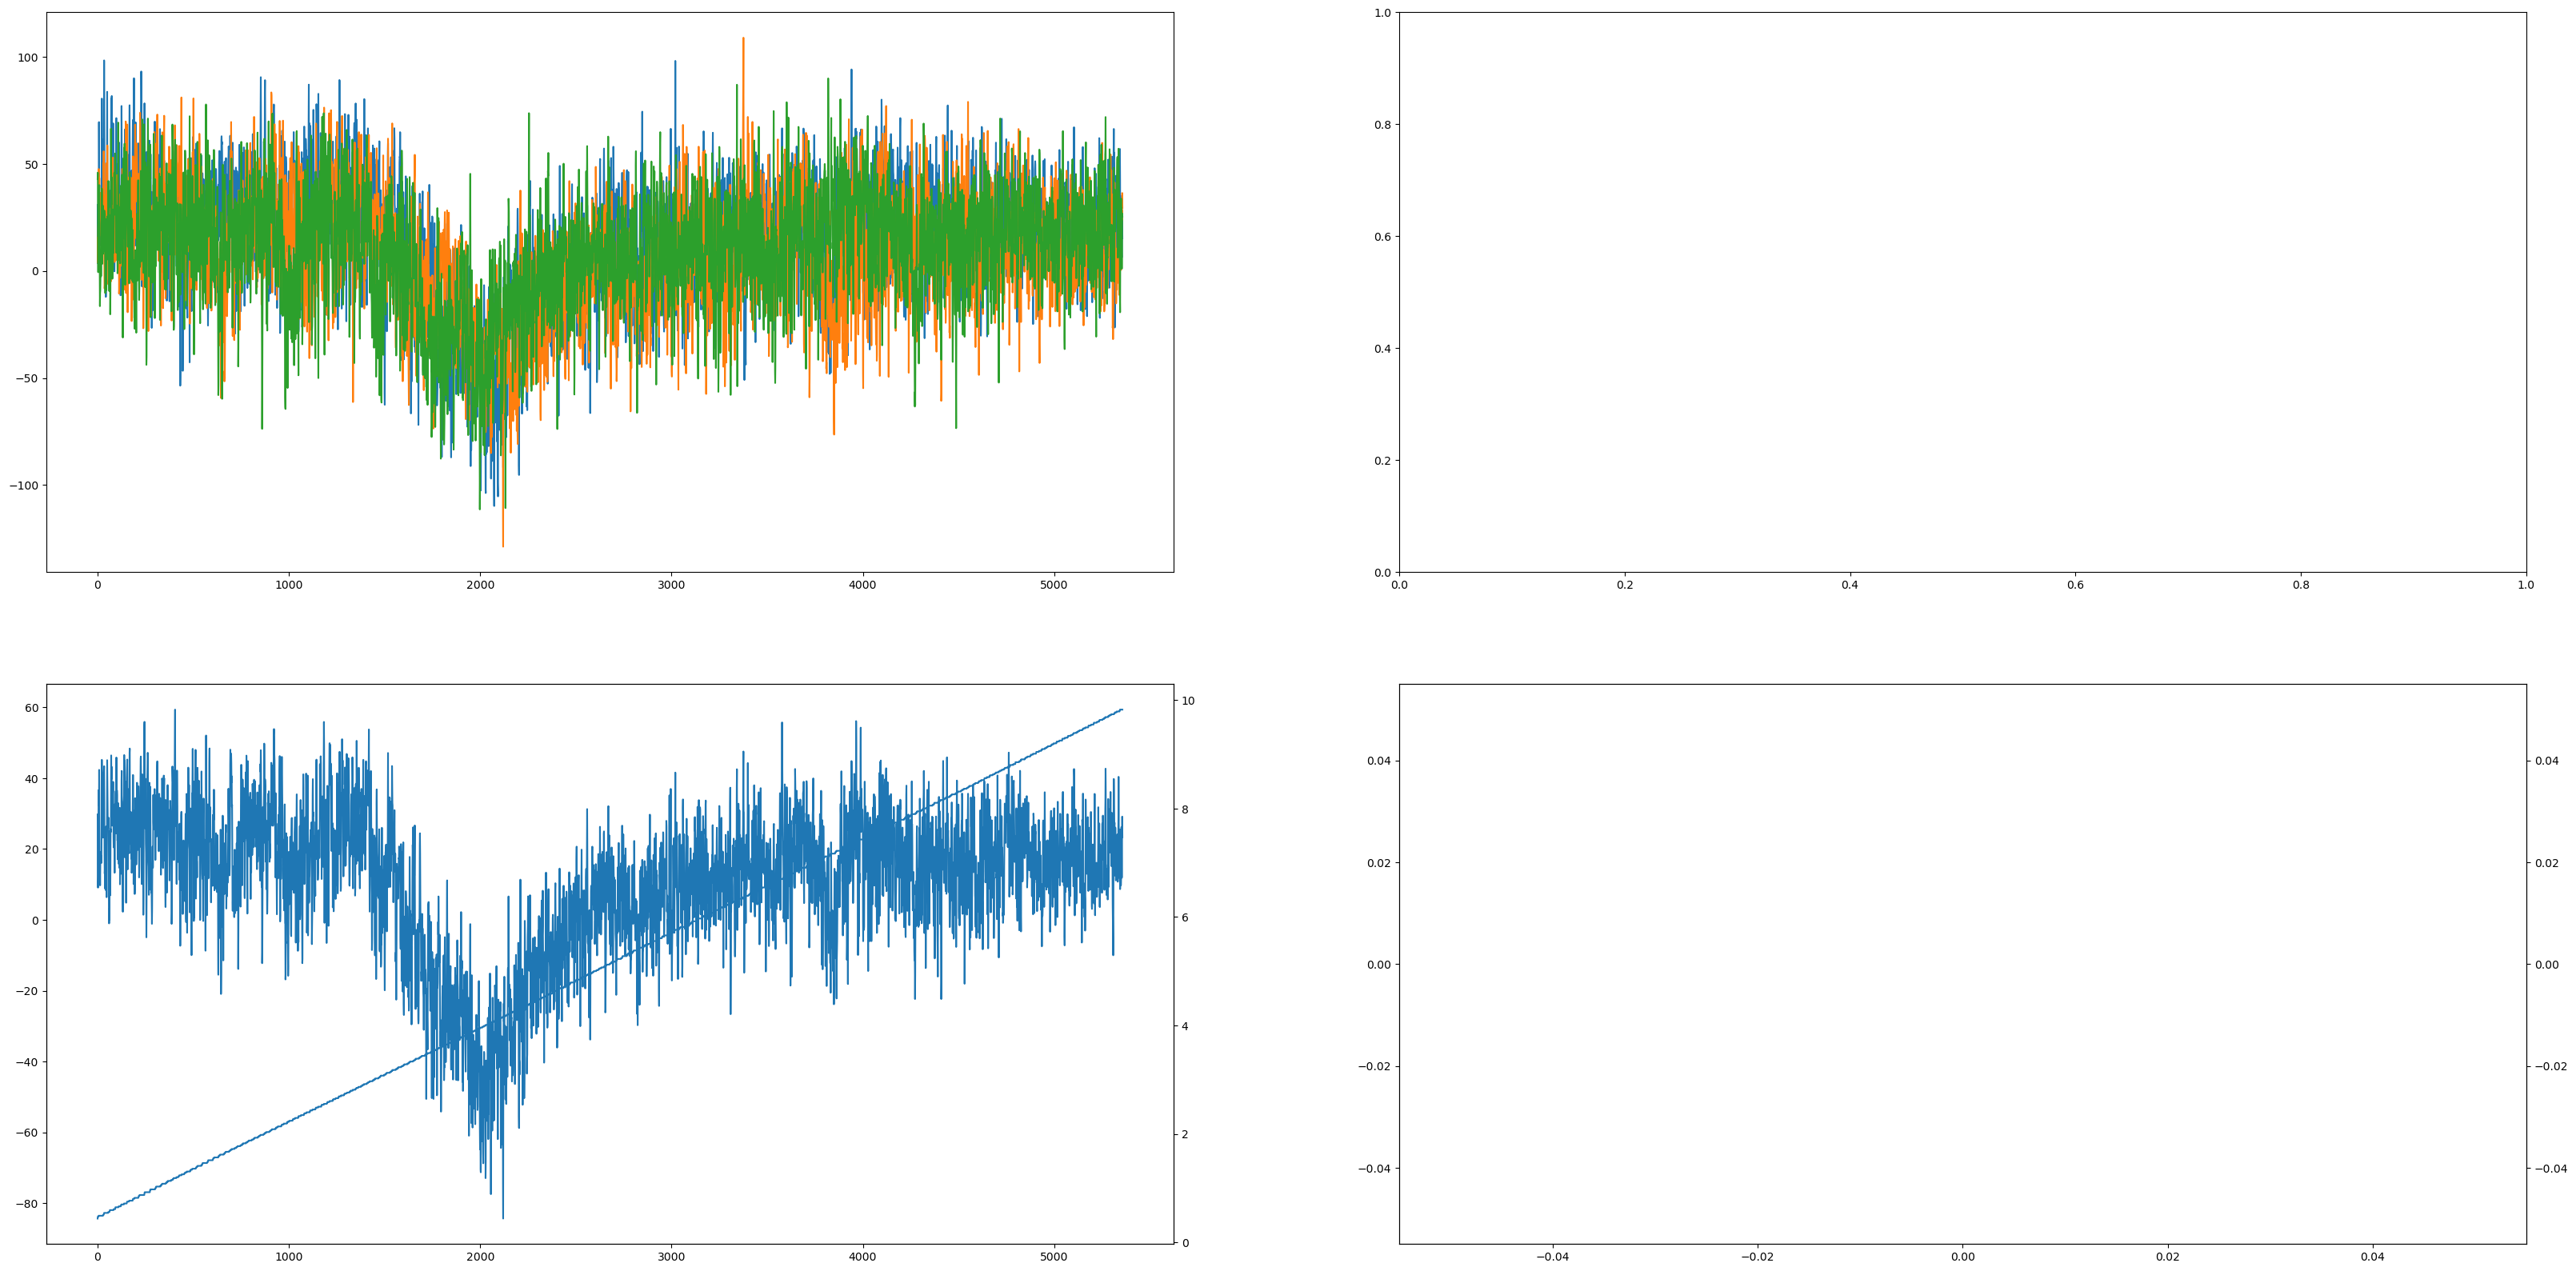

In [33]:
fig, ax1 = plt.subplots(len(aligned_responses), 2, figsize=(40, 20))

for idx, key in enumerate(aligned_responses):
    for l in aligned_responses[key]:
        ax1[0, idx].plot(l)
    ax1[1, idx].plot(np.mean(aligned_responses[key], 0))
    ax2 = ax1[1, idx].twinx()
    ax2.plot(np.mean(aligned_arena[key], 0))

plt.show()

# Average csv files

In [3]:
def get_csv_files(directory):
  """
  Returns a list of all CSV files in the given directory.
  """
  return [file for file in os.listdir(directory) if file.endswith(".csv")]

# Example usage:
directory_path = "/Volumes/2p_data/Galadriel/ASAP7y_jrGECO1a/ER4d-split/250418_fly7/analysis/csvs"  # Replace with the actual path
csv_files = get_csv_files(directory_path)

In [9]:
channel = 'Ch1'
ch_fluor = []
arena_pos = []
for f in csv_files:
    df_trial = pd.read_csv(os.path.join(directory_path, f))
    corr_ch = df_trial[f'{channel} ROI 1'] - df_trial[f'{channel} bg ROI 1']
    ch_fluor.append(corr_ch)

    arena_pos.append(df_trial[' Arena DAC1'])
    time = df_trial['Time(ms)']/1000

average_response = np.mean(ch_fluor, axis=0)
average_arena = np.mean(arena_pos, axis=0)

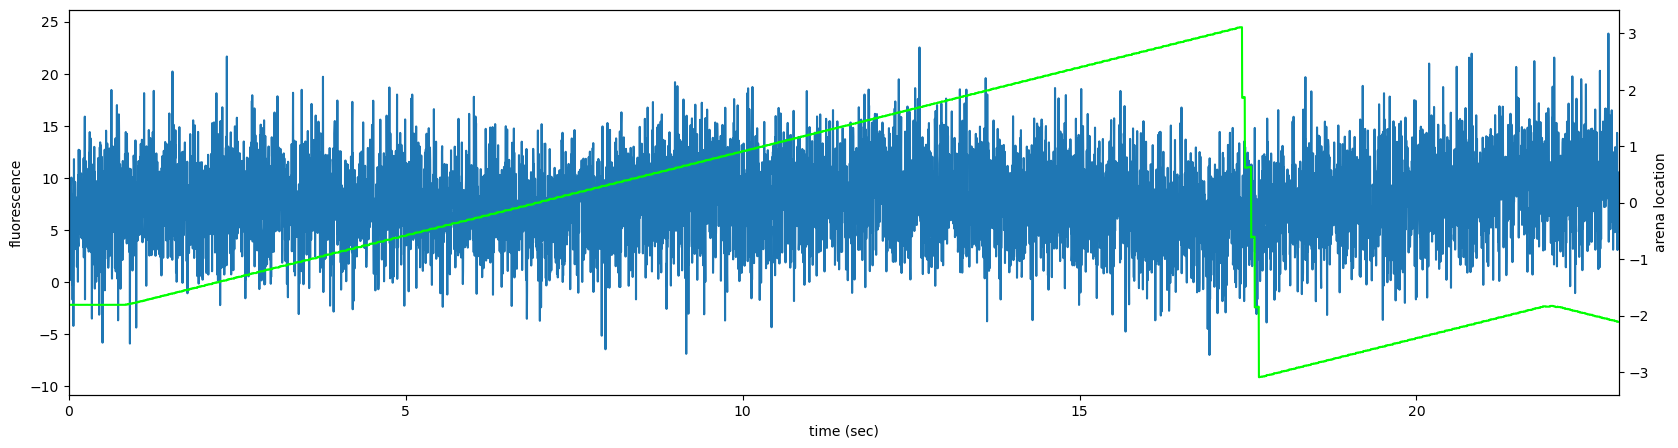

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()
ax1.set_xlim((0, 23))

ax1.plot(time, average_response)
ax1.set_xlabel('time (sec)')
ax1.set_ylabel('fluorescence')
ax2.plot(time, average_arena, color='lime')
ax2.set_ylabel('arena location')

plt.show()

# open csv files

In [ ]:
csvname = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/roi_csvs/{data_directory}.csv')

df_trial = pd.read_csv(csvname)

In [6]:
df_trial

Time(ms)   Arena DAC1   Arena DAC1_cartx   Arena DAC1_carty  \
0          0.0000    -1.806838          -0.233856          -0.972271   
1          2.9232    -1.808908          -0.235868          -0.971785   
2          5.8464    -1.809415          -0.236360          -0.971665   
3          8.7696    -1.809039          -0.235995          -0.971754   
4         11.6928    -1.808793          -0.235757          -0.971812   
...           ...          ...                ...                ...   
17099  49983.7968    -1.808556          -0.235526          -0.971868   
17100  49986.7200    -1.810097          -0.237024          -0.971504   
17101  49989.6432    -1.809499          -0.236442          -0.971645   
17102  49992.5664    -1.809077          -0.236032          -0.971745   
17103  49995.4896    -1.809415          -0.236360          -0.971665   

       Ch2 ROI 1  Ch2 bg ROI 1  Ch1 ROI 1  Ch1 bg ROI 1  
0      48.630769     15.923077  22.738462      9.061538  
1      68.615385     23.230769  12.961538     13.446154  
2      42.469231     13.984615  15.376923     26.869231  
3      37.400000     24.876923  25.730769     28.961538  
4      49.553846      9.030769  20.361538      9.769231  
...          ...           ...        ...           ...  
17099  59.038462      6.376923  25.515385     13.815385  
17100  35.807692      8.653846  24.553846     17.807692  
17101  51.769231     21.276923  24.423077     21.430769  
17102  48.123077     12.415385  21.253846      7.115385  
17103  56.700000      6.238462  23.730769     11.946154  

[17104 rows x 8 columns]

In [ ]:
plt.plot(df_trial[' Arena DAC1_cartx'], df_trial[' Arena DAC1_carty'], '.')
plt.plot(df_trial[' Arena DAC1_cartx'][0], df_trial[' Arena DAC1_carty'][0], '.')
plt.show()

In [ ]:
import math

x = df_trial[' Arena DAC1_cartx']
y = df_trial[' Arena DAC1_carty']

alpha = 90

x_rotated = x * math.cos(alpha) - y * math.sin(alpha)
y_rotated = x * math.sin(alpha) + y * math.cos(alpha)

plt.plot(x_rotated, y_rotated)
plt.plot(x_rotated[0], y_rotated[0], '.')
plt.show()

In [ ]:
rho, theta = st2p.utilities.cart2pol(df_trial[' Arena DAC1_cartx'], df_trial[' Arena DAC1_carty'])

rotate_theta = theta - theta[0]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, rho)
ax.plot(rotate_theta[0], rho[0], '.')
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

In [ ]:
unwrap_theta = np.unwrap(df_trial[' Arena DAC1'])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(unwrap_theta, rho)
ax.plot(unwrap_theta[0], rho[0], '.')
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

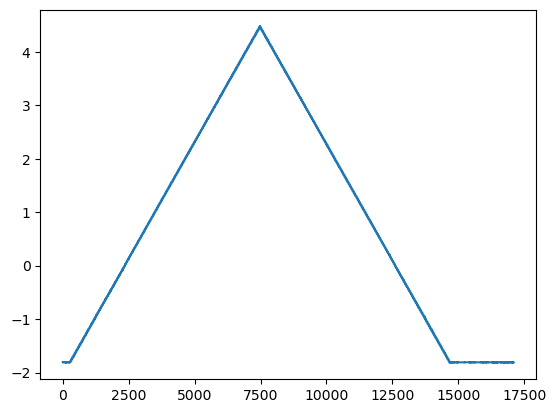

In [72]:
unwrap_theta = np.unwrap(df_trial[' Arena DAC1'])
plt.plot(unwrap_theta)

In [117]:
# df_trial = df_aligned
channels = ['Ch1', 'Ch2']

glom_fluor_corr = df_trial[f'{channels[1]} ROI 1'] - df_trial[f'{channels[1]} bg ROI 1']
glom_red_fluor_corr = df_trial[f'{channels[0]} ROI 1'] - df_trial[f'{channels[0]} bg ROI 1']

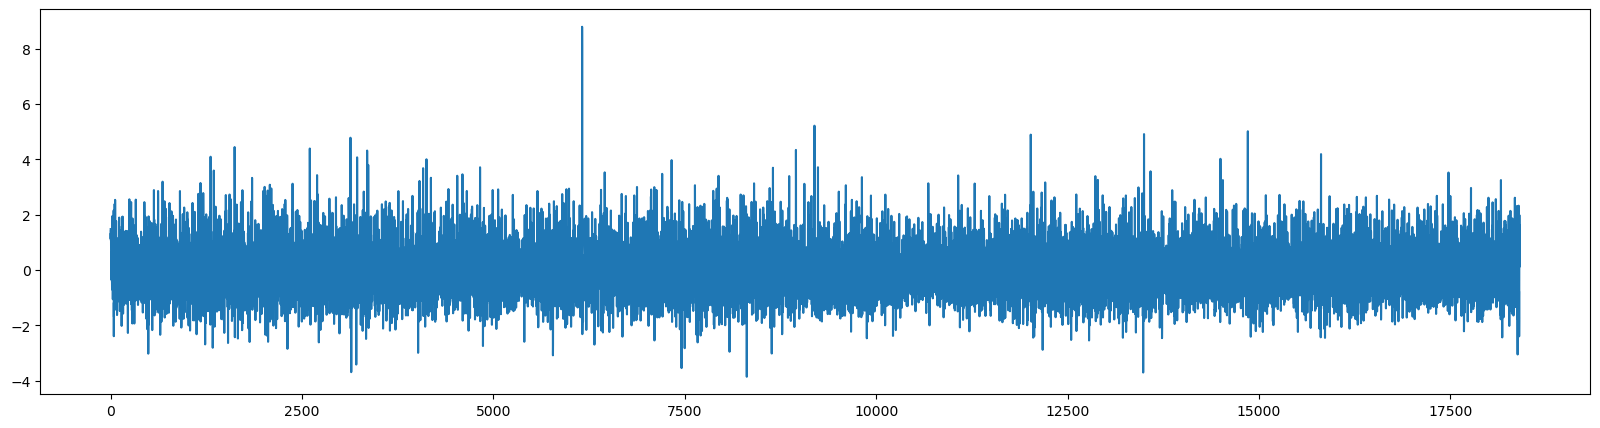

In [118]:
diff_fluor = np.diff(lowpass)

plt.figure(figsize=(20, 5))
plt.plot(diff_fluor)
plt.show()

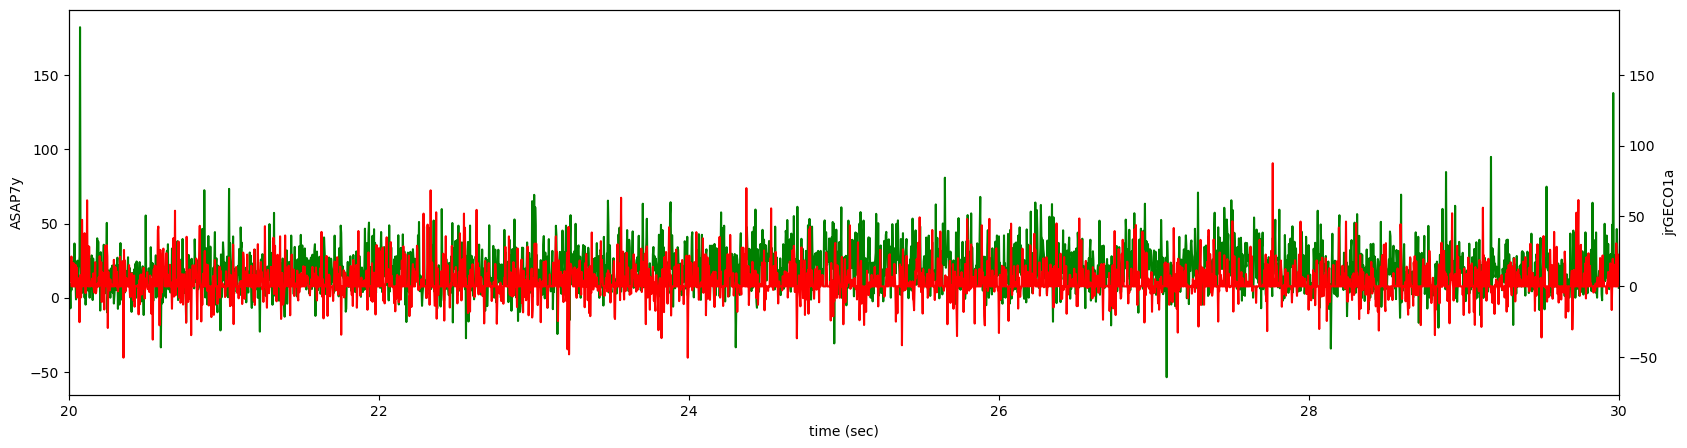

In [121]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()
ax1.plot(df_trial['Time(ms)']/1000, glom_fluor_corr, 'green')
ax1.set_ylabel('ASAP7y')
ax2.plot(df_trial['Time(ms)']/1000, glom_red_fluor_corr, 'red')
ax2.set_ylabel('jrGECO1a')

ax1.set_xlabel('time (sec)')
ax1.set_xlim(20, 30)

plt.show()

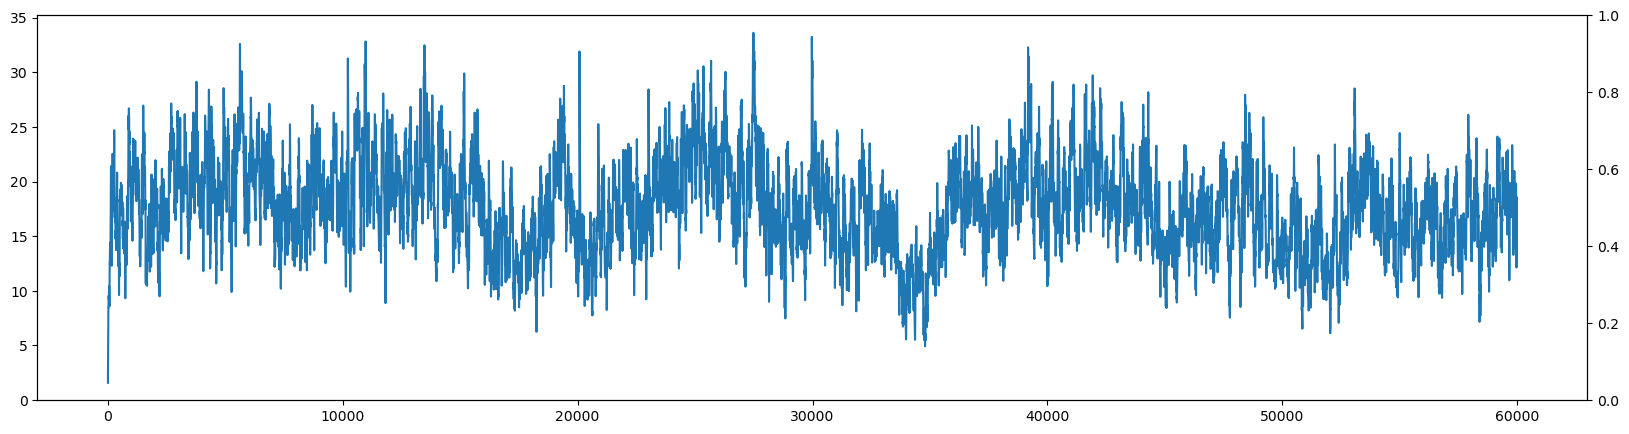

In [81]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()

ax1.plot(time, lowpass)

In [211]:
roi_num = 2

glom_fluor_corr = corr_roi_fluor['Ch2'][roi_num]
glom_red_fluor_corr = corr_roi_fluor['Ch1'][roi_num]

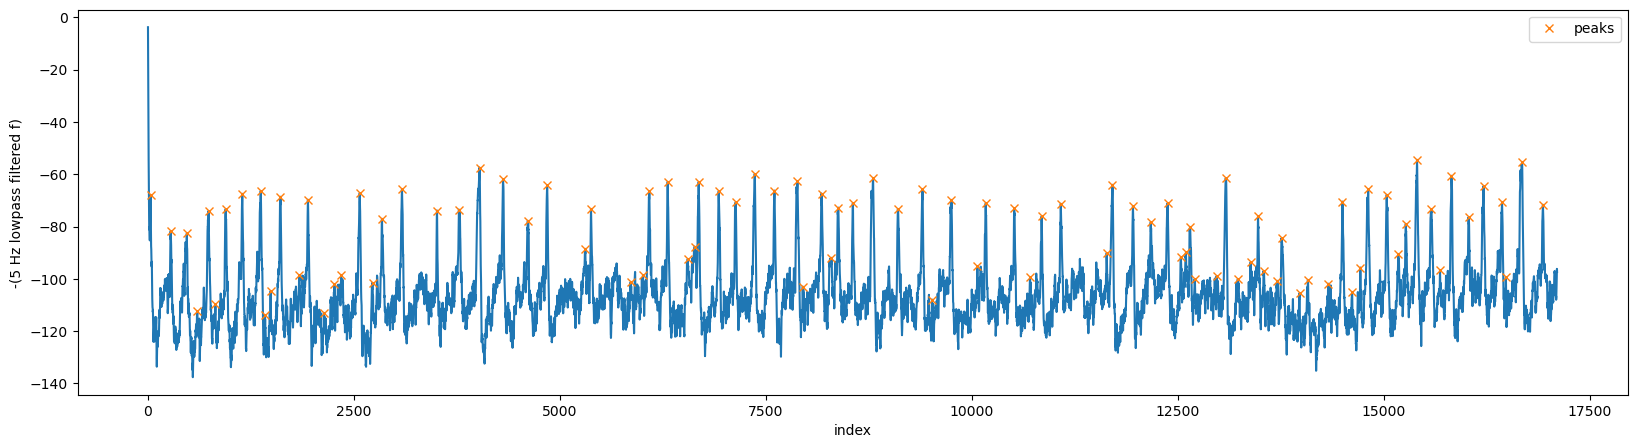

In [212]:
cutoff = 5

time = df_trial['Time(ms)']
samp_rate = 1/metadata['linescan_size']['scan_line_period']

lowpass = butter_lowpass_filter(glom_fluor_corr, cutoff, samp_rate, 1)

flipped_lowpass = -lowpass

peaks, properties = sp.signal.find_peaks(flipped_lowpass, prominence=15, wlen=100)#, width=(25,75))

plt.figure(figsize=(20, 5))
plt.plot(flipped_lowpass, label='_nolegend_')
plt.plot(peaks, flipped_lowpass[peaks], 'x')
plt.legend(['peaks'])
plt.xlabel('index')
plt.ylabel(f'-({cutoff} Hz lowpass filtered f)')
# plt.xlim(0/metadata['linescan_size']['scan_line_period'], 10/metadata['linescan_size']['scan_line_period'])
plt.show()

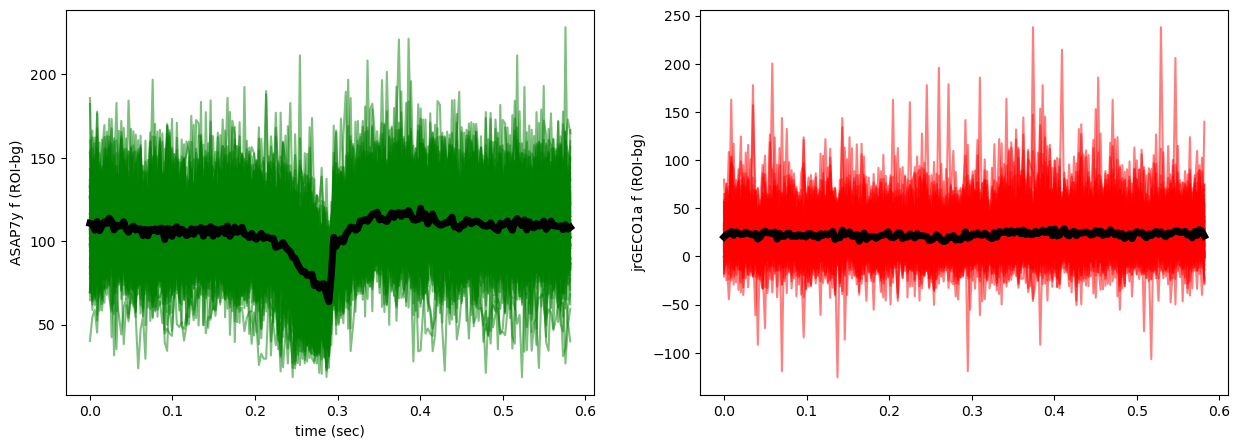

In [213]:
before = 100
after = 100

before_array = peaks - before
after_array = peaks + after

if before_array[0] < 0:
    before_array = np.delete(before_array, 0)
    after_array = np.delete(after_array, 0)

if after_array[-1] > len(glom_fluor_corr):
    before_array = np.delete(before_array, -1)
    after_array = np.delete(after_array, -1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

average_burst = np.zeros((len(before_array), before+after))
red_average_burst = np.zeros((len(before_array), before+after))
for idx, v in enumerate(before_array):
    current_burst = glom_fluor_corr[v:after_array[idx]]
    burst_time = np.arange(0, len(current_burst)/samp_rate, 1/samp_rate)
    ax1.plot(burst_time, current_burst, color='green', alpha=0.5)

    red_current_burst = glom_red_fluor_corr[v:after_array[idx]]
    ax2.plot(burst_time, red_current_burst, color='red', alpha=0.5)

    average_burst[idx,:] = current_burst
    red_average_burst[idx,:] = red_current_burst

average_burst = average_burst.mean(axis=0)
red_average_burst = red_average_burst.mean(axis=0)
ax1.plot(burst_time, average_burst, color='black', linewidth=5)
ax2.plot(burst_time, red_average_burst, color='black', linewidth=5)

# # turn off extra ticks and labels
# ax3.tick_params(axis='x', which='both', bottom=False, top=False)
# ax4.tick_params(axis='x', which='both', bottom=False, top=False)
# ax3.set_xticklabels([])
# ax4.set_xticklabels([])

# # fix zorder
# ax1.set_zorder(3)
# ax2.set_zorder(1)
# ax3.set_zorder(4)
# ax4.set_zorder(2)

# axes labels
ax1.set_ylabel('ASAP7y f (ROI-bg)')
ax2.set_ylabel('jrGECO1a f (ROI-bg)')
ax1.set_xlabel('time (sec)')

plt.show()

In [19]:
start_time = 25
end_time = 35
samp_rate = 1/metadata['linescan_size']['scan_line_period']

start_index = int(start_time * samp_rate)
end_index = int(end_time * samp_rate)

test_data = glom_fluor_corr[start_index:end_index]
test_time = df_trial['Time(ms)'][start_index:end_index]

red_test_data = glom_red_fluor_corr[start_index:end_index]

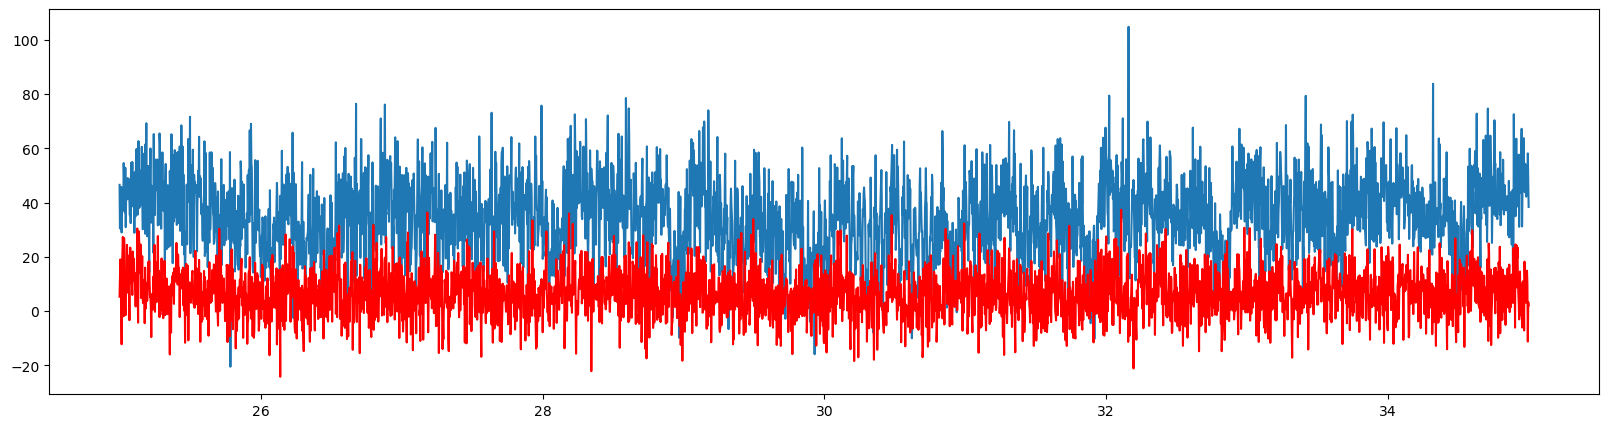

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(test_time/1000, test_data)
plt.plot(test_time/1000, red_test_data, color='red')
plt.show()

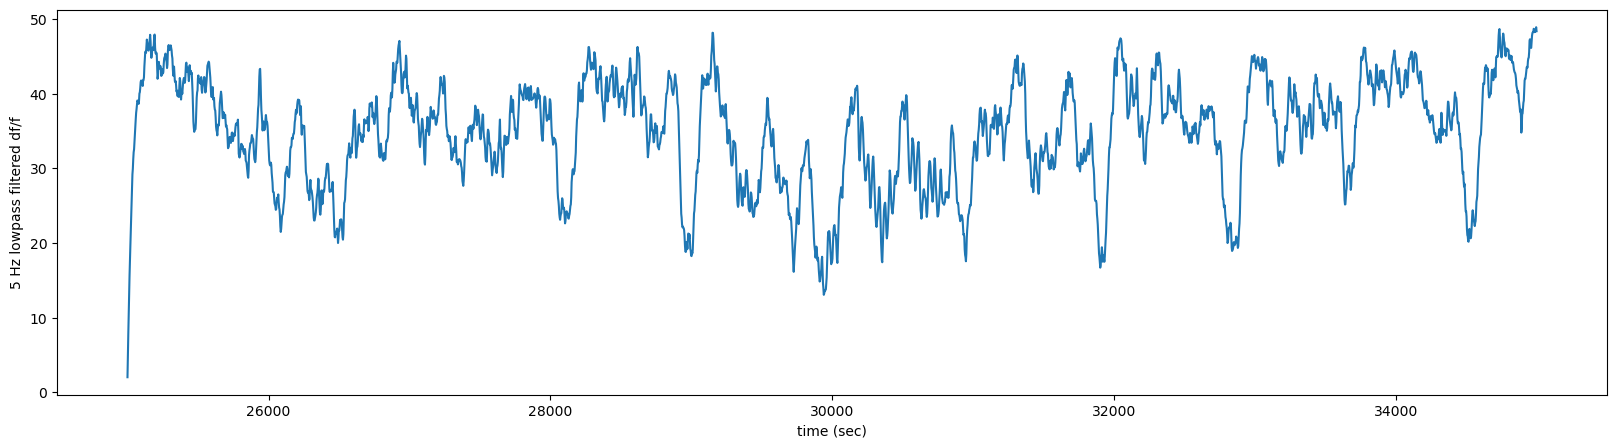

In [30]:
cutoff = 5

lowpass = butter_lowpass_filter(test_data, cutoff, samp_rate, 1)

plt.figure(figsize=(20, 5))
plt.plot(test_time, lowpass)
plt.xlabel('time (sec)')
plt.ylabel(f'{cutoff} Hz lowpass filtered df/f')
# plt.xlim(28000, 28200)
plt.show()

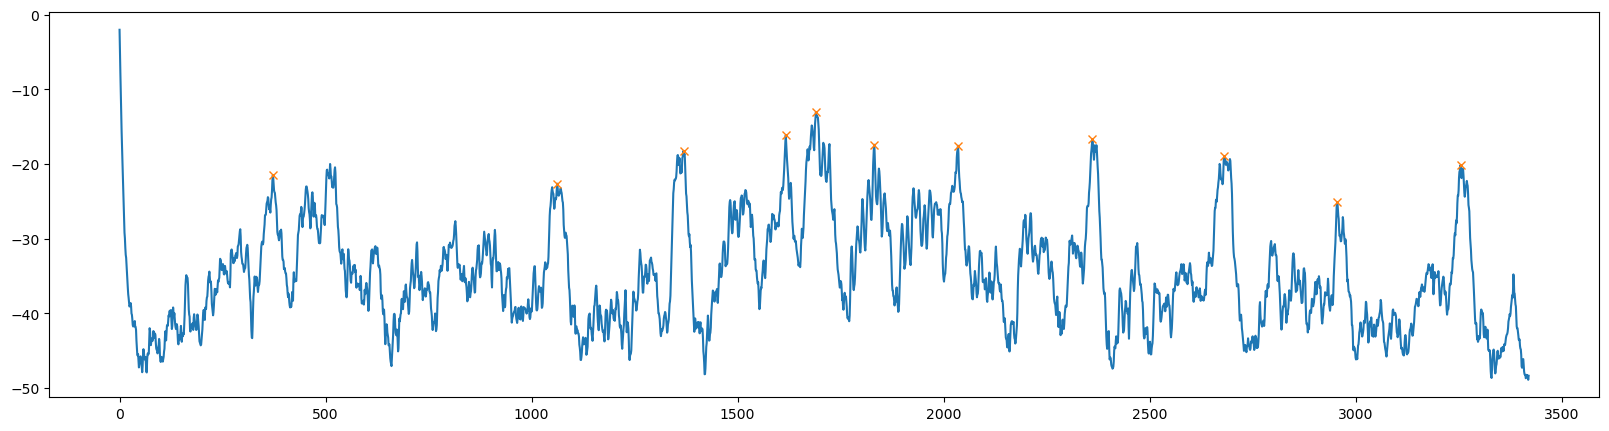

In [10]:
flipped_lowpass = -lowpass

peaks, properties = sp.signal.find_peaks(flipped_lowpass, prominence=15, wlen=100)#, width=(25,75))

plt.figure(figsize=(20, 5))
plt.plot(flipped_lowpass)
plt.plot(peaks, flipped_lowpass[peaks], 'x')
plt.show()

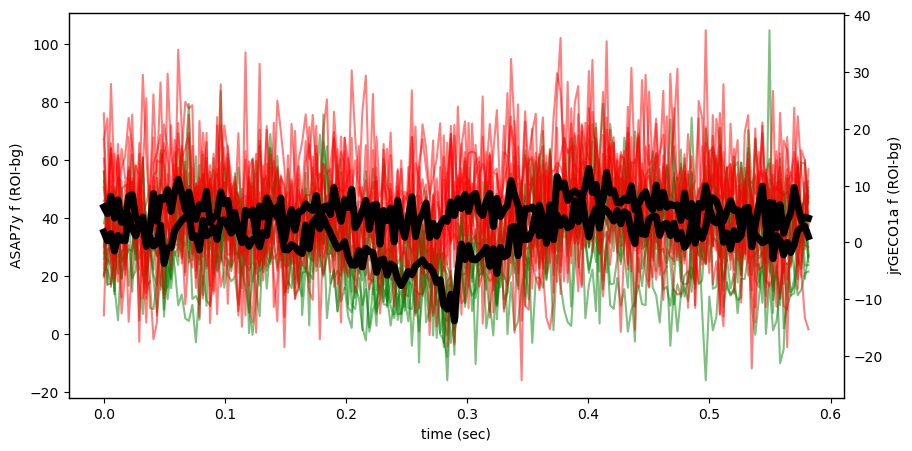

In [27]:
before = 100
after = 100

before_array = peaks - before
after_array = peaks + after

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax3 = ax1.twiny()
ax4 = ax2.twiny()

average_burst = np.zeros((len(before_array), before+after))
red_average_burst = np.zeros((len(before_array), before+after))
for idx, v in enumerate(before_array):
    current_burst = test_data[v:after_array[idx]]
    burst_time = np.arange(0, len(current_burst)/samp_rate, 1/samp_rate)
    ax1.plot(burst_time, current_burst, color='green', alpha=0.5)

    red_current_burst = red_test_data[v:after_array[idx]]
    ax2.plot(burst_time, red_current_burst, color='red', alpha=0.5)

    average_burst[idx,:] = current_burst
    red_average_burst[idx,:] = red_current_burst

average_burst = average_burst.mean(axis=0)
red_average_burst = red_average_burst.mean(axis=0)
ax3.plot(burst_time, average_burst, color='black', linewidth=5)
ax4.plot(burst_time, red_average_burst, color='black', linewidth=5)

# turn off extra ticks and labels
ax3.tick_params(axis='x', which='both', bottom=False, top=False)
ax4.tick_params(axis='x', which='both', bottom=False, top=False)
ax3.set_xticklabels([])
ax4.set_xticklabels([])

# axes labels
ax1.set_ylabel('ASAP7y f (ROI-bg)')
ax2.set_ylabel('jrGECO1a f (ROI-bg)')
ax1.set_xlabel('time (sec)')

plt.show()

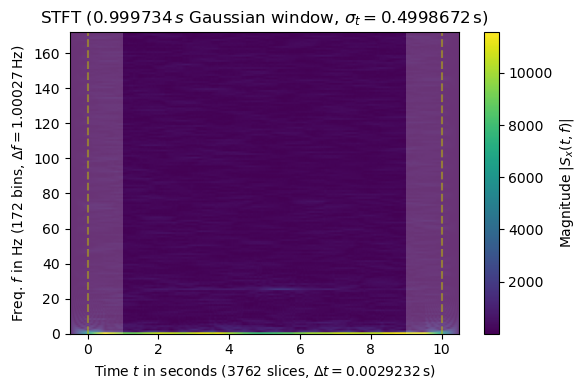

In [ ]:
# short time FFT spectrogram
x = np.array(test_data)
T_x = samp_rate
N = len(test_data)
t_x = test_time

w = sp.signal.windows.gaussian(int(samp_rate), std=int(samp_rate/2), sym=True)# spectrogram default
SFT = sp.signal.ShortTimeFFT(w, hop=1, fs=T_x)#, scale_to='magnitude')
Sx = SFT.stft(x)  # perform the STFT

fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2] # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={int(samp_rate/2)*SFT.T}\,$s)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')
# ax1.plot(t_x, f_i, 'r--', alpha=.5, label='$f_i(t)$')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)
# ax1.legend()
# ax1.set_ylim(0, 10)
fig1.tight_layout()
plt.show()